# Moon Cycles Deep Search (v2) — Model Bakeoff

Goal of this notebook (in one sentence):
- **Check if astro features contain any real predictive edge for BTC daily direction, or if it is basically random.**

This notebook supports TWO feature modes (choose in the config cell):
1. **Moon-only**: only Moon phase features (very strict test of the Moon idea).
2. **All ephemeris features**: positions of all bodies + aspects + phases/elongations ("maximum" astro info).

Why we do this research:
- We want a *clean*, *honest* answer about whether ephemeris-derived data can predict direction.
- If there is no edge even with full ephemeris features, we should not build more complexity on top.

How we try to be honest (very important):
1. We use a strict **time split** (no shuffling). This reduces future leakage.
2. We test several model families (linear, trees, small neural net, XGBoost).
3. We tune parameters using **validation** only.
4. We keep **test** for the final check.
5. We report statistical checks (p-value vs 50% and Wilson 95% CI), because 52% can be noise.

What "edge" means here (very simple rules of thumb):
- If test accuracy CI includes 50% and p-value is not small (e.g. > 0.05), it can be random.
- Recall-min below 50% means one side (UP or DOWN) is basically not predictable.
- MCC near 0 means "almost no correlation".

Extra practical check:
- At the end we also run a **very simple trading simulation** from the model signals.
  This is NOT production-grade trading. It is just a sanity-check: "does the signal help at all?".


In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

PROJECT_ROOT = Path('/home/rut/ostrofun')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from RESEARCH2.Moon_cycles.moon_data import (
    MoonLabelConfig,
    build_moon_phase_features,
    load_market_slice,
)
from RESEARCH2.Moon_cycles.bakeoff_utils import run_moon_model_bakeoff
from RESEARCH2.Moon_cycles.eval_visuals import VisualizationConfig, evaluate_with_visuals

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)
from RESEARCH2.Moon_cycles.trading_utils import (
    TradingConfig,
    backtest_long_flat_signals,
    build_signal_from_proba,
    plot_backtest_price_and_equity,
    sweep_trading_params,
)

from RESEARCH2.Moon_cycles.ephemeris_data import (
    EphemerisFeatureConfig,
    build_ephemeris_feature_set,
)


In [2]:
# ------------------------------
# Research configuration block
# ------------------------------

START_DATE = '2017-11-01'
END_DATE = None
USE_CACHE = True
VERBOSE = True

# Choose what features we feed into the model.
# - 'moon_only'      : strict test of Moon phase idea
# - 'ephemeris_all'  : ALL features from ephemeris (positions + aspects + phases)
FEATURE_SET = 'ephemeris_all'

# IMPORTANT: we keep caches separate per feature mode to avoid mixing results.
# Otherwise, you could accidentally load a cached run that was trained on a
# different feature set (which would make the research dishonest).
CACHE_NAMESPACE = 'research2_moon' if FEATURE_SET == 'moon_only' else 'research2_ephem'

# Ephemeris feature config (used only when FEATURE_SET='ephemeris_all').
# This is the "maximum information" setup:
# - coord_mode='both' -> geo + helio bodies and aspects
# - include_pair_aspects=True -> planet pair interactions
# - include_phases=True -> moon phase + planet elongations
EPHEM_CFG = EphemerisFeatureConfig(
    coord_mode='both',
    orb_mult=0.25,
    include_pair_aspects=True,
    include_phases=True,
    add_trig_for_longitudes=True,
    add_trig_for_moon_phase=True,
    add_trig_for_elongations=True,
    exclude_bodies=(),
)

# Label parameters that stay fixed while we tune Gaussian window/std.
# These labels try to create a balanced UP/DOWN set using detrended future returns.
LABEL_CFG = MoonLabelConfig(
    horizon=1,
    move_share=0.5,
    label_mode='balanced_detrended',
    price_mode='raw',
)

# If True, we use a wider Gaussian grid.
# Why: a narrow grid can miss the "only" area where any weak edge exists.
# Note: widening the grid increases runtime. Cache helps a lot.
WIDE_GAUSS_GRID = True

# Gaussian grid to tune (label detrending parameters).
# The idea: different smoothing strength changes what is considered a "real move".
if WIDE_GAUSS_GRID:
    GAUSS_WINDOWS = [51, 101, 151, 201, 251, 301, 351, 401]
    GAUSS_STDS = [10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 70.0, 90.0]
else:
    GAUSS_WINDOWS = [101, 151, 201, 251, 301]
    GAUSS_STDS = [30.0, 50.0, 70.0, 90.0]

# Threshold tuning penalties (helps avoid one-class prediction collapse).
# In plain words:
# - gap penalty punishes "UP recall is good but DOWN recall is terrible" (or vice versa)
# - prior penalty punishes predicting UP too often (or too rarely) vs the true UP share
THRESHOLD_GAP_PENALTY = 0.25
THRESHOLD_PRIOR_PENALTY = 0.05

# XGBoost params (kept as baseline).
XGB_PARAMS = {
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.03,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'early_stopping_rounds': 50,
}

# Dark-theme visuals.
VIS_CFG = VisualizationConfig(
    rolling_window_days=90,
    rolling_min_periods=30,
    probability_bins=64,
)

FEATURE_LABEL = 'Moon-only' if FEATURE_SET == 'moon_only' else 'All ephemeris features'

print('Config loaded.')
print('FEATURE_SET =', FEATURE_SET)
print('FEATURE_LABEL =', FEATURE_LABEL)
print('CACHE_NAMESPACE =', CACHE_NAMESPACE)
print('WIDE_GAUSS_GRID =', WIDE_GAUSS_GRID)
print('Gaussian grid size =', len(GAUSS_WINDOWS) * len(GAUSS_STDS))


Config loaded.
FEATURE_SET = ephemeris_all
FEATURE_LABEL = All ephemeris features
CACHE_NAMESPACE = research2_ephem
WIDE_GAUSS_GRID = True
Gaussian grid size = 72


In [3]:
# -------------------------------------------
# Load market data and build astro features
# -------------------------------------------

# 1) Market data (daily close). This is the only market input we use.
#    We do NOT use it as a feature here. It is used only for:
#    - label creation (UP/DOWN target)
#    - plotting price and equity curves

df_market = load_market_slice(
    start_date=START_DATE,
    end_date=END_DATE,
    use_cache=USE_CACHE,
    verbose=VERBOSE,
)

# 2) Feature matrix (depends on FEATURE_SET).
if FEATURE_SET == 'moon_only':
    df_features = build_moon_phase_features(
        df_market=df_market,
        use_cache=USE_CACHE,
        verbose=VERBOSE,
        progress=True,
    )
else:
    # WARNING: first run can take time because we compute thousands of ephemeris days.
    # After that, it is cached and repeated runs are fast.
    df_features = build_ephemeris_feature_set(
        df_market=df_market,
        cfg=EPHEM_CFG,
        cache_namespace=CACHE_NAMESPACE,
        use_cache=USE_CACHE,
        verbose=VERBOSE,
        progress=True,
    )

print('Market rows:', len(df_market))
print('Feature rows:', len(df_features))
print('Feature columns (excluding date):', len([c for c in df_features.columns if c != 'date']))
print('Market range:', df_market['date'].min().date(), '->', df_market['date'].max().date())

display(df_features.head(5))


📂 Loading from cache: research2_moon__market__2017-11-01__8953c00f.parquet
📍 Расчёт ГЕОЦЕНТРИЧЕСКИХ координат (Земля в центре)...


Calculating bodies: 100%|██████████| 3017/3017 [00:00<00:00, 15970.51it/s]


☀️ Расчёт ГЕЛИОЦЕНТРИЧЕСКИХ координат (Солнце в центре)...


Calculating bodies: 100%|██████████| 3017/3017 [00:00<00:00, 29430.94it/s]


✅ Объединено: 78442 записей из 2 систем координат
📐 Расчёт GEO-аспектов (orb×0.25)...


Calculating aspects (orb=0.25): 100%|██████████| 3017/3017 [00:00<00:00, 54475.94it/s]


☀️ Расчёт HELIO-аспектов (orb×0.25)...


Calculating aspects (orb=0.25): 100%|██████████| 3017/3017 [00:00<00:00, 45531.53it/s]


✅ Объединено 44885 аспектов из 2 систем


Calculating phases & elongations: 100%|██████████| 3017/3017 [00:00<00:00, 229359.37it/s]


✅ Рассчитано 3017 дней: фаза Луны + элонгации планет


/home/rut/ostrofun/RESEARCH2/Moon_cycles/ephemeris_data.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{c}_{suffix}_sin"] = np.sin(rad)
/home/rut/ostrofun/RESEARCH2/Moon_cycles/ephemeris_data.py:113: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{c}_{suffix}_cos"] = np.cos(rad)
/home/rut/ostrofun/RESEARCH2/Moon_cycles/ephemeris_data.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

✅ Cached: research2_ephem__ephemeris_features__2017-11-01_both_orb0.25_phases__48f3de8f.parquet (5.83 MB)
Ephemeris feature set ready: 3017 days, 1464 features
Market rows: 3017
Feature rows: 3017
Feature columns (excluding date): 1464
Market range: 2017-11-01 -> 2026-02-03


date  geo_Jupiter_lon  geo_Lilith_lon  geo_Mars_lon  geo_MeanNode_lon  geo_Mercury_lon  geo_Moon_lon  geo_Neptune_lon  geo_Pluto_lon  geo_Saturn_lon  \
0 2017-11-01       214.662680      269.089371    185.828074        140.126691       232.905646    356.209228       341.596174     287.127692      264.609855   
1 2017-11-02       214.880702      269.200882    186.459109        140.073706       234.398481      9.936665       341.584602     287.144191      264.703843   
2 2017-11-03       215.098611      269.312392    187.090093        140.020725       235.882907     24.114155       341.573540     287.161145      264.798752   
3 2017-11-04       215.316399      269.423908    187.721044        139.967753       237.358797     38.675453       341.562998     287.178557      264.894571   
4 2017-11-05       215.534050      269.535436    188.351973        139.914796       238.825957     53.505699       341.552986     287.196428      264.991291   

   geo_Sun_lon  geo_TrueNode_lon  geo_Uranus_lon  geo_Venus_lon  helio_Jupiter_lon  helio_Lilith_lon  helio_Mars_lon  helio_MeanNode_lon  helio_Mercury_lon  \
0   218.755657        141.000541       26.027296     201.888931         213.922622               0.0      166.897768                 0.0         264.405752   
1   219.755898        140.886151       25.987864     203.138561         213.998536               0.0      167.335848                 0.0         267.170495   
2   220.756617        140.729548       25.948669     204.388586         214.074457               0.0      167.774059                 0.0         269.948818   
3   221.757832        140.543240       25.909734     205.639012         214.150391               0.0      168.212414                 0.0         272.744202   
4   222.759566        140.346856       25.871080     206.889845         214.226343               0.0      168.650923                 0.0         275.560181   

   helio_Moon_lon  helio_Neptune_lon  helio_Pluto_lon  helio_Saturn_lon  helio_Sun_lon  helio_TrueNode_lon  helio_Uranus_lon  helio_Venus_lon  \
0       38.656841         343.189218       288.711173        268.672960            0.0                 0.0         26.651594       178.281542   
1       39.684317         343.195247       288.716318        268.703025            0.0                 0.0         26.662464       179.901135   
2       40.715872         343.201280       288.721465        268.733094            0.0                 0.0         26.673338       181.520200   
3       41.750083         343.207323       288.726623        268.763173            0.0                 0.0         26.684221       183.138725   
4       42.785277         343.213381       288.731795        268.793266            0.0                 0.0         26.695120       184.756696   

   geo_Jupiter_speed  geo_Lilith_speed  geo_Mars_speed  geo_MeanNode_speed  geo_Mercury_speed  geo_Moon_speed  geo_Neptune_speed  geo_Pluto_speed  \
0           0.218073          0.111513        0.631064           -0.052984           1.497015       13.493332          -0.011823         0.016273   
1           0.217967          0.111509        0.631007           -0.052984           1.488648       13.959043          -0.011319         0.016726   
2           0.217850          0.111512        0.630965           -0.052978           1.480186       14.384714          -0.010804         0.017183   
3           0.217722          0.111521        0.630938           -0.052965           1.471566       14.718352          -0.010278         0.017641   
4           0.217579          0.111534        0.630922           -0.052948           1.462713       14.916938          -0.009745         0.018100   

   geo_Saturn_speed  geo_Sun_speed  geo_TrueNode_speed  geo_Uranus_speed  geo_Venus_speed  helio_Jupiter_speed  helio_Lilith_speed  helio_Mars_speed  \
0          0.093524       1.000008           -0.091415         -0.039543         1.249436             0.075913                 0.0          0.438017   
1          0.094450   

## Bakeoff Run

This section runs a grid over Gaussian label parameters and evaluates multiple models.

Important:
- We select the best Gaussian params **per model** using **validation metrics**.
- Only after that we look at test metrics.

In [4]:
bakeoff = run_moon_model_bakeoff(
    df_market=df_market,
    df_moon_features=df_features,
    gauss_windows=GAUSS_WINDOWS,
    gauss_stds=GAUSS_STDS,
    label_cfg=LABEL_CFG,
    include_xgb=True,
    xgb_params=XGB_PARAMS,
    threshold_gap_penalty=THRESHOLD_GAP_PENALTY,
    threshold_prior_penalty=THRESHOLD_PRIOR_PENALTY,
    cache_namespace=CACHE_NAMESPACE,
    use_cache=USE_CACHE,
    verbose=VERBOSE,
)

results_table = bakeoff['results_table']
best_by_val = bakeoff['best_by_val_table']
best_runs = bakeoff['best_runs']

print('Bakeoff results rows:', len(results_table))
print('Best-by-validation table (one row per model):')
display(best_by_val)


📂 Loading from cache: research2_moon__labels__2017-11-01_h1_gw51__e2d053e1.parquet
Merged dataset: 3013 samples (ALL days, forward-filled)
Features: 1464
✅ Cached: research2_ephem__dataset__2017-11-01_h1_gw51__28ba1c35.parquet (5.85 MB)


/mnt/w/WSL/btc/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [07:03:20] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


✅ Cached: research2_ephem__bakeoff_run__gw51__48da9e80.pkl (0.20 MB)
[1/288] left=287 bakeoff src=computed model=xgb gw=51 std=10.0 | val rmin=0.440 gap=0.129 mcc=0.009 acc=0.502 | test rmin=0.252 gap=0.532 mcc=0.043 acc=0.509 p=0.371 | BEST model=xgb gw=51 std=10.0 | val rmin=0.440 gap=0.129 mcc=0.009 acc=0.502 | test rmin=0.252 gap=0.532 mcc=0.043 acc=0.509 p=0.371
✅ Cached: research2_ephem__bakeoff_run__gw51__fc6454ee.pkl (0.20 MB)
[2/288] left=286 bakeoff src=computed model=logreg gw=51 std=10.0 | val rmin=0.514 gap=0.012 mcc=0.039 acc=0.520 | test rmin=0.017 gap=0.969 mcc=0.013 acc=0.485 p=0.76 | BEST model=xgb gw=51 std=10.0 | val rmin=0.440 gap=0.129 mcc=0.009 acc=0.502 | test rmin=0.252 gap=0.532 mcc=0.043 acc=0.509 p=0.371
✅ Cached: research2_ephem__bakeoff_run__gw51__e65c35f4.pkl (0.20 MB)
[3/288] left=285 bakeoff src=computed model=rf gw=51 std=10.0 | val rmin=0.427 gap=0.100 mcc=-0.045 acc=0.476 | test rmin=0.397 gap=0.245 mcc=0.041 acc=0.515 p=0.27 | BEST model=rf gw=51 st

model  threshold  val_score   val_acc   val_mcc  val_recall_min  val_recall_gap  test_acc  test_bal_acc  test_mcc  test_recall_min  test_recall_gap  \
0      rf       0.48   0.459473  0.526549  0.059802        0.485597        0.088566  0.539823      0.540623  0.081825         0.480349         0.120548   
1     xgb       0.51   0.537654  0.539823  0.079528        0.539419        0.000865  0.522124      0.521723  0.044179         0.431111         0.181224   
2     mlp       0.05   0.495897  0.497788 -0.004435        0.497630        0.000295  0.493363      0.494185 -0.012527         0.308370         0.371630   
3  logreg       0.10   0.520746  0.526549  0.052704        0.523364        0.006047  0.488938      0.504017  0.035087         0.017167         0.973700   

   p_value_vs_random  accuracy_ci95_low  accuracy_ci95_high  baseline_majority_test_acc  baseline_random_test_acc  test_up_share  pred_up_share  gauss_window  \
0           0.049802           0.493731            0.585243                    0.493363                  0.471239       0.493363       0.559735           401   
1           0.185754           0.476081            0.567794                    0.497788                  0.462389       0.497788       0.409292           201   
2           0.628997           0.447522            0.539315                    0.497788                  0.462389       0.497788       0.685841           201   
3           0.697536           0.443142            0.534921                    0.484513                  0.464602       0.484513       0.986726           151   

   gauss_std  
0       90.0  
1       40.0  
2       40.0  
3       20.0

In [5]:
# -------------------------------------------------
# Show top configs per model by VALIDATION quality
# -------------------------------------------------
# This makes it easy to see if any model consistently beats random.

show_cols = [
    'model',
    'gauss_window',
    'gauss_std',
    'val_recall_min',
    'val_recall_gap',
    'val_mcc',
    'val_acc',
    'test_recall_min',
    'test_recall_gap',
    'test_mcc',
    'test_acc',
    'p_value_vs_random',
    'baseline_majority_test_acc',
    'baseline_random_test_acc',
    'pred_up_share',
]

for model in sorted(results_table['model'].unique()):
    sub = results_table[results_table['model'] == model].copy()
    sub = sub.sort_values(
        ['val_recall_min', 'val_recall_gap', 'val_mcc', 'val_acc'],
        ascending=[False, True, False, False],
    )
    print()
    print('='*90)
    print('MODEL:', model)
    display(sub[show_cols].head(10))


MODEL: logreg


model  gauss_window  gauss_std  val_recall_min  val_recall_gap   val_mcc   val_acc  test_recall_min  test_recall_gap  test_mcc  test_acc  \
81   logreg           151       20.0        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700  0.035087  0.488938   
117  logreg           201       20.0        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700  0.035087  0.488938   
153  logreg           251       20.0        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700  0.035087  0.488938   
189  logreg           301       20.0        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700  0.035087  0.488938   
225  logreg           351       20.0        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700  0.035087  0.488938   
261  logreg           401       20.0        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700  0.035087  0.488938   
85   logreg           151       25.0        0.523148        0.014987  0.061233  0.530973         0.012931         0.982524  0.044753  0.491150   
121  logreg           201       25.0        0.523148        0.014987  0.061233  0.530973         0.012931         0.982524  0.044753  0.491150   
157  logreg           251       25.0        0.523148        0.014987  0.061233  0.530973         0.012931         0.982524  0.044753  0.491150   
193  logreg           301       25.0        0.523148        0.014987  0.061233  0.530973         0.012931         0.982524  0.044753  0.491150   

     p_value_vs_random  baseline_majority_test_acc  baseline_random_test_acc  pred_up_share  
81            0.697536                    0.484513                  0.464602       0.986726  
117           0.697536                    0.484513                  0.464602       0.986726  
153           0.697536                    0.484513                  0.464602       0.986726  
189           0.697536                    0.484513                  0.464602       0.986726  
225           0.697536                    0.484513                  0.464602       0.986726  
261           0.697536                    0.484513                  0.464602       0.986726  
85            0.663947                    0.486726                  0.462389       0.991150  
121           0.663947                    0.486726                  0.462389       0.991150  
157           0.663947                    0.486726                  0.462389       0.991150  
193           0.663947                    0.486726                  0.462389       0.991150


MODEL: mlp


model  gauss_window  gauss_std  val_recall_min  val_recall_gap   val_mcc   val_acc  test_recall_min  test_recall_gap  test_mcc  test_acc  \
131   mlp           201       40.0        0.497630        0.000295 -0.004435  0.497788         0.308370         0.371630 -0.012527  0.493363   
247   mlp           351       70.0        0.495968        0.004032 -0.004013  0.497788         0.306034         0.375784 -0.013105  0.488938   
71    mlp           101       90.0        0.490476        0.017788 -0.001256  0.500000         0.263158         0.437735 -0.039989  0.480088   
251   mlp           351       90.0        0.481481        0.006557 -0.030395  0.484513         0.294372         0.397935 -0.014518  0.488938   
67    mlp           101       70.0        0.480952        0.039709  0.001611  0.502212         0.280702         0.411263 -0.029990  0.484513   
107   mlp           151       90.0        0.480392        0.003479 -0.035567  0.482301         0.307018         0.380482 -0.005928  0.495575   
143   mlp           201       90.0        0.473430        0.044937 -0.008182  0.497788         0.257642         0.446394 -0.042834  0.477876   
139   mlp           201       70.0        0.470588        0.021347 -0.037304  0.482301         0.299559         0.384885 -0.017332  0.491150   
207   mlp           301       50.0        0.465686        0.026249 -0.042187  0.480088         0.271930         0.433427 -0.025205  0.486726   
243   mlp           351       50.0        0.465686        0.026249 -0.042187  0.480088         0.271930         0.433427 -0.025205  0.486726   

     p_value_vs_random  baseline_majority_test_acc  baseline_random_test_acc  pred_up_share  
131           0.628997                    0.497788                  0.462389       0.685841  
247           0.697536                    0.486726                  0.473451       0.688053  
71            0.814246                    0.495575                  0.462389       0.719027  
251           0.697536                    0.488938                  0.475664       0.699115  
67            0.759743                    0.495575                  0.460177       0.705752  
107           0.592950                    0.495575                  0.460177       0.690265  
143           0.838363                    0.493363                  0.469027       0.723451  
139           0.663947                    0.497788                  0.464602       0.692478  
207           0.729532                    0.495575                  0.462389       0.716814  
243           0.729532                    0.495575                  0.462389       0.716814


MODEL: rf


model  gauss_window  gauss_std  val_recall_min  val_recall_gap   val_mcc   val_acc  test_recall_min  test_recall_gap  test_mcc  test_acc  \
286    rf           401       90.0        0.485597        0.088566  0.059802  0.526549         0.480349         0.120548  0.081825  0.539823   
22     rf            51       40.0        0.483471        0.021291 -0.011740  0.493363         0.509091         0.021082  0.039259  0.519912   
26     rf            51       50.0        0.483471        0.021291 -0.011740  0.493363         0.509091         0.021082  0.039259  0.519912   
30     rf            51       70.0        0.483471        0.021291 -0.011740  0.493363         0.509091         0.021082  0.039259  0.519912   
178    rf           251       90.0        0.479839        0.029965 -0.010313  0.493363         0.334783         0.354407  0.025627  0.508850   
214    rf           301       90.0        0.477366        0.029811 -0.015420  0.491150         0.480519         0.139390  0.101363  0.548673   
130    rf           201       40.0        0.473934        0.057187  0.005051  0.504425         0.524444         0.030622  0.079548  0.539823   
166    rf           251       40.0        0.473029        0.090952  0.037074  0.515487         0.427313         0.217132  0.073505  0.535398   
202    rf           301       40.0        0.473029        0.090952  0.037074  0.515487         0.427313         0.217132  0.073505  0.535398   
238    rf           351       40.0        0.473029        0.090952  0.037074  0.515487         0.427313         0.217132  0.073505  0.535398   

     p_value_vs_random  baseline_majority_test_acc  baseline_random_test_acc  pred_up_share  
286           0.049802                    0.493363                  0.471239       0.559735  
22            0.211983                    0.486726                  0.464602       0.488938  
26            0.211983                    0.486726                  0.464602       0.488938  
30            0.211983                    0.486726                  0.464602       0.488938  
178           0.371003                    0.491150                  0.471239       0.676991  
214           0.021500                    0.488938                  0.475664       0.568584  
130           0.049802                    0.497788                  0.462389       0.484513  
166           0.072362                    0.497788                  0.462389       0.608407  
202           0.072362                    0.497788                  0.462389       0.608407  
238           0.072362                    0.497788                  0.462389       0.608407


MODEL: xgb


model  gauss_window  gauss_std  val_recall_min  val_recall_gap   val_mcc   val_acc  test_recall_min  test_recall_gap  test_mcc  test_acc  \
128   xgb           201       40.0        0.539419        0.000865  0.079528  0.539823         0.431111         0.181224  0.044179  0.522124   
64    xgb           101       70.0        0.533058        0.081228  0.147344  0.570796         0.425439         0.181704  0.033130  0.515487   
68    xgb           101       90.0        0.533058        0.081228  0.147344  0.570796         0.425439         0.181704  0.033130  0.515487   
88    xgb           151       30.0        0.516807        0.020576  0.054122  0.526549         0.398268         0.239741  0.037350  0.515487   
92    xgb           151       40.0        0.516529        0.092995  0.126183  0.559735         0.460526         0.030545 -0.048424  0.475664   
104   xgb           151       90.0        0.514706        0.025617  0.054793  0.528761         0.294643         0.341322 -0.073805  0.466814   
16    xgb            51       30.0        0.514286        0.080756  0.109482  0.557522         0.395455         0.251097  0.043394  0.524336   
168   xgb           251       50.0        0.504032        0.064595  0.072435  0.533186         0.468750         0.075110  0.012645  0.506637   
96    xgb           151       50.0        0.502392        0.073739  0.078551  0.542035         0.352679         0.230655 -0.065750  0.469027   
164   xgb           251       40.0        0.497925        0.066056  0.061889  0.528761         0.364444         0.265512 -0.005808  0.497788   

     p_value_vs_random  baseline_majority_test_acc  baseline_random_test_acc  pred_up_share  
128           0.185754                    0.497788                  0.462389       0.409292  
64            0.270468                    0.495575                  0.460177       0.590708  
68            0.270468                    0.495575                  0.462389       0.590708  
88            0.270468                    0.488938                  0.469027       0.619469  
92            0.860343                    0.495575                  0.464602       0.515487  
104           0.927638                    0.495575                  0.460177       0.329646  
16            0.161637                    0.486726                  0.462389       0.373894  
168           0.407050                    0.495575                  0.462389       0.462389  
96            0.913757                    0.495575                  0.464602       0.384956  
164           0.556098                    0.497788                  0.462389       0.367257

## Extra sweep: threshold penalties (small grid)

Why we do this:
- The model outputs probabilities close to 0.50 in many cases.
- A bad threshold rule can collapse into "predict UP always" or "predict DOWN always".
- We already tune the threshold on validation, but the tuning objective has penalties.

So here we do a *small* grid over those penalty weights to check if the result is sensitive.

Important honesty note:
- We still treat TEST as a report-only set. We do not pick penalties by TEST.


In [6]:
# Small grid: (gap_penalty, prior_penalty)
# We keep it small on purpose to avoid huge multiple-comparison noise.
GAP_PENALTIES = [0.10, 0.25, 0.40]
PRIOR_PENALTIES = [0.00, 0.05, 0.10]

# We test penalties on the BEST gaussian configs we already found (one per model).
# This is much cheaper than re-running the full gaussian grid for every penalty pair.
best_gauss_pairs = (
    best_by_val[['gauss_window', 'gauss_std']]
    .drop_duplicates()
    .sort_values(['gauss_window', 'gauss_std'])
    .reset_index(drop=True)
)

penalty_rows = []

for _, r in best_gauss_pairs.iterrows():
    gw = int(r['gauss_window'])
    gs = float(r['gauss_std'])

    for gp in GAP_PENALTIES:
        for pp in PRIOR_PENALTIES:
            tmp = run_moon_model_bakeoff(
                df_market=df_market,
                df_moon_features=df_features,
                gauss_windows=[gw],
                gauss_stds=[gs],
                label_cfg=LABEL_CFG,
                include_xgb=True,
                xgb_params=XGB_PARAMS,
                threshold_gap_penalty=float(gp),
                threshold_prior_penalty=float(pp),
                cache_namespace=CACHE_NAMESPACE,
                use_cache=USE_CACHE,
                verbose=VERBOSE,
            )

            t = tmp['best_by_val_table'].copy()
            t['gauss_window'] = gw
            t['gauss_std'] = gs
            t['gap_penalty'] = float(gp)
            t['prior_penalty'] = float(pp)
            penalty_rows.append(t)

df_penalties = pd.concat(penalty_rows, ignore_index=True)

# For inspection we sort by validation quality first (our honest selection rule).
df_penalties_sorted = df_penalties.sort_values(
    ['model', 'val_recall_min', 'val_recall_gap', 'val_mcc', 'val_acc'],
    ascending=[True, False, True, False, False],
)

display(
    df_penalties_sorted[[
        'model','gauss_window','gauss_std','gap_penalty','prior_penalty',
        'val_recall_min','val_recall_gap','val_mcc','val_acc',
        'test_recall_min','test_recall_gap','test_mcc','test_acc','p_value_vs_random',
    ]].head(30)
)


📂 Loading from cache: research2_ephem__dataset__2017-11-01_h1_gw151__f09240a0.parquet
✅ Cached: research2_ephem__bakeoff_run__gw151__843f927d.pkl (0.20 MB)
[1/4] left=3 bakeoff src=computed model=xgb gw=151 std=20.0 | val rmin=0.454 gap=0.172 mcc=0.081 acc=0.535 | test rmin=0.479 gap=0.057 mcc=0.016 acc=0.509 p=0.371 | BEST model=xgb gw=151 std=20.0 | val rmin=0.454 gap=0.172 mcc=0.081 acc=0.535 | test rmin=0.479 gap=0.057 mcc=0.016 acc=0.509 p=0.371
✅ Cached: research2_ephem__bakeoff_run__gw151__2ee53e57.pkl (0.20 MB)
[2/4] left=2 bakeoff src=computed model=logreg gw=151 std=20.0 | val rmin=0.523 gap=0.006 mcc=0.053 acc=0.527 | test rmin=0.017 gap=0.974 mcc=0.035 acc=0.489 p=0.698 | BEST model=xgb gw=151 std=20.0 | val rmin=0.454 gap=0.172 mcc=0.081 acc=0.535 | test rmin=0.479 gap=0.057 mcc=0.016 acc=0.509 p=0.371
✅ Cached: research2_ephem__bakeoff_run__gw151__9bcf5dc4.pkl (0.20 MB)
[3/4] left=1 bakeoff src=computed model=rf gw=151 std=20.0 | val rmin=0.437 gap=0.049 mcc=-0.077 acc=0.

model  gauss_window  gauss_std  gap_penalty  prior_penalty  val_recall_min  val_recall_gap   val_mcc   val_acc  test_recall_min  test_recall_gap  \
3    logreg           151       20.0         0.10           0.00        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700   
7    logreg           151       20.0         0.10           0.05        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700   
11   logreg           151       20.0         0.10           0.10        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700   
15   logreg           151       20.0         0.25           0.00        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700   
19   logreg           151       20.0         0.25           0.05        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700   
23   logreg           151       20.0         0.25           0.10        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700   
27   logreg           151       20.0         0.40           0.00        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700   
31   logreg           151       20.0         0.40           0.05        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700   
35   logreg           151       20.0         0.40           0.10        0.523364        0.006047  0.052704  0.526549         0.017167         0.973700   
39   logreg           201       40.0         0.10           0.00        0.497630        0.008594  0.003846  0.502212         0.008811         0.991189   
43   logreg           201       40.0         0.10           0.05        0.497630        0.008594  0.003846  0.502212         0.008811         0.991189   
47   logreg           201       40.0         0.10           0.10        0.497630        0.008594  0.003846  0.502212         0.008811         0.991189   
51   logreg           201       40.0         0.25           0.00        0.497630        0.008594  0.003846  0.502212         0.008811         0.991189   
55   logreg           201       40.0         0.25           0.05        0.497630        0.008594  0.003846  0.502212         0.008811         0.991189   
59   logreg           201       40.0         0.25           0.10        0.497630        0.008594  0.003846  0.502212         0.008811         0.991189   
63   logreg           201       40.0         0.40           0.00        0.497630        0.008594  0.003846  0.502212         0.008811         0.991189   
67   logreg           201       40.0         0.40           0.05        0.497630        0.008594  0.003846  0.502212         0.008811         0.991189   
71   logreg           201       40.0         0.40           0.10        0.497630        0.008594  0.003846  0.502212         0.008811         0.991189   
75   logreg           401       90.0         0.10           0.00        0.489712        0.012680 -0.007874  0.495575         0.000000         1.000000   
79   logreg           401       90.0         0.10           0.05        0.489712        0.012680 -0.007874  0.495575         0.000000         1.000000   
83   logreg           401       90.0         0.10           0.10        0.489712        0.012680 -0.007874  0.495575         0.000000         1.000000   
87   logreg           401       90.0         0.25           0.00        0.489712        0.012680 -0.007874  0.495575         0.000000         1.000000   
91   logreg           401       90.0         0.25           0.05        0.489712        0.012680 -0.007874  0.495575         0.000000         1.000000   
95   logreg           401       90.0         0.25           0.10        0.489712        0.012680 -0.007874  0.495575         0.000000         1.000000   
99   logreg           401       90.0         0.40           0.00        0.489712        0.012680 -0.007874  0.495575         0.000000         1.000000   
10

In [19]:
pd.set_option('display.max_rows', None)

In [21]:
df_penalties_sorted

model  threshold  val_score   val_acc   val_mcc  val_recall_min  val_recall_gap  test_acc  test_bal_acc  test_mcc  test_recall_min  test_recall_gap  \
3    logreg       0.10   0.522760  0.526549  0.052704        0.523364        0.006047  0.488938      0.504017  0.035087         0.017167         0.973700   
7    logreg       0.10   0.521654  0.526549  0.052704        0.523364        0.006047  0.488938      0.504017  0.035087         0.017167         0.973700   
11   logreg       0.10   0.520547  0.526549  0.052704        0.523364        0.006047  0.488938      0.504017  0.035087         0.017167         0.973700   
15   logreg       0.10   0.521853  0.526549  0.052704        0.523364        0.006047  0.488938      0.504017  0.035087         0.017167         0.973700   
19   logreg       0.10   0.520746  0.526549  0.052704        0.523364        0.006047  0.488938      0.504017  0.035087         0.017167         0.973700   
23   logreg       0.10   0.519640  0.526549  0.052704        0.523364        0.006047  0.488938      0.504017  0.035087         0.017167         0.973700   
27   logreg       0.10   0.520946  0.526549  0.052704        0.523364        0.006047  0.488938      0.504017  0.035087         0.017167         0.973700   
31   logreg       0.10   0.519839  0.526549  0.052704        0.523364        0.006047  0.488938      0.504017  0.035087         0.017167         0.973700   
35   logreg       0.10   0.518733  0.526549  0.052704        0.523364        0.006047  0.488938      0.504017  0.035087         0.017167         0.973700   
39   logreg       0.23   0.496771  0.502212  0.003846        0.497630        0.008594  0.502212      0.504405  0.066372         0.008811         0.991189   
43   logreg       0.23   0.495333  0.502212  0.003846        0.497630        0.008594  0.502212      0.504405  0.066372         0.008811         0.991189   
47   logreg       0.23   0.493895  0.502212  0.003846        0.497630        0.008594  0.502212      0.504405  0.066372         0.008811         0.991189   
51   logreg       0.23   0.495482  0.502212  0.003846        0.497630        0.008594  0.502212      0.504405  0.066372         0.008811         0.991189   
55   logreg       0.23   0.494044  0.502212  0.003846        0.497630        0.008594  0.502212      0.504405  0.066372         0.008811         0.991189   
59   logreg       0.23   0.492606  0.502212  0.003846        0.497630        0.008594  0.502212      0.504405  0.066372         0.008811         0.991189   
63   logreg       0.23   0.494193  0.502212  0.003846        0.497630        0.008594  0.502212      0.504405  0.066372         0.008811         0.991189   
67   logreg       0.23   0.492755  0.502212  0.003846        0.497630        0.008594  0.502212      0.504405  0.066372         0.008811         0.991189   
71   logreg       0.23   0.491317  0.502212  0.003846        0.497630        0.008594  0.502212      0.504405  0.066372         0.008811         0.991189   
75   logreg       0.11   0.488444  0.495575 -0.007874        0.489712        0.012680  0.493363      0.500000  0.000000         0.000000         1.000000   
79   logreg       0.11   0.486232  0.495575 -0.007874        0.489712        0.012680  0.493363      0.500000  0.000000         0.000000         1.000000   
83   logreg       0.11   0.484019  0.495575 -0.007874        0.489712        0.012680  0.493363      0.500000  0.000000         0.000000         1.000000   
87   logreg       0.11   0.486542  0.495575 -0.007874        0.489712        0.012680  0.493363      0.500000  0.000000         0.000000         1.000000   
91   logreg       0.11   0.484329  0.495575 -0.007874        0.489712        0.012680  0.493363      0.500000  0.000000         0.000000         1.000000   
95   logreg       0.11   0.482117  0.495575 -0.007874        0.489712        0.012680  0.493363      0.500000  0.000000         0.000000         1.000000   
99   logreg       0.11   0.484640  0.495575 -0.007874        0.489712        0.01

## Visual Diagnostics For Winners

For each model, we take its best-by-validation configuration and plot:
- confusion matrix
- predicted vs true label background over price
- rolling metrics
- probability histogram

This is the most "human readable" way to see if the model actually does something useful.


####################################################################################################
WINNER MODEL: logreg


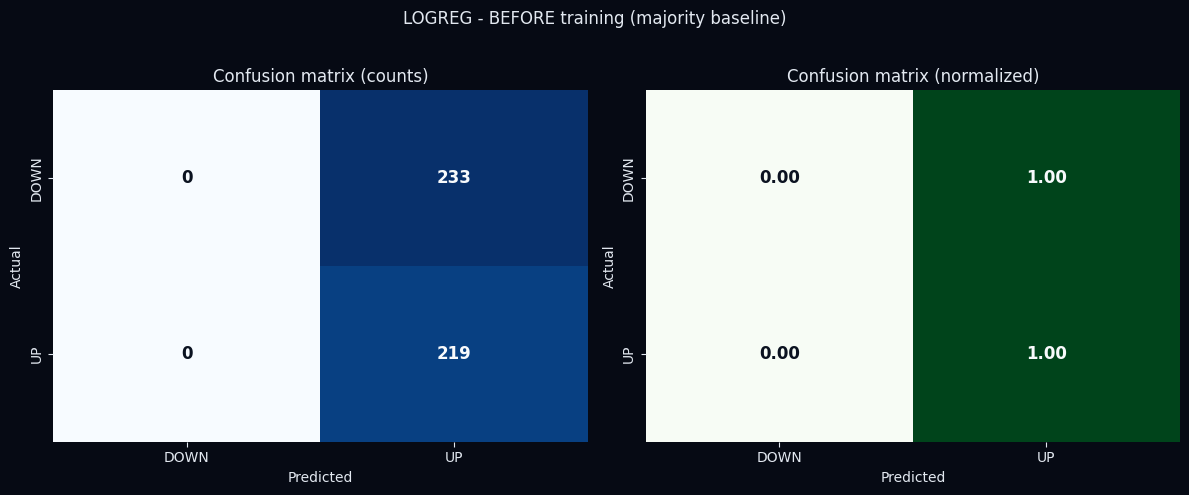

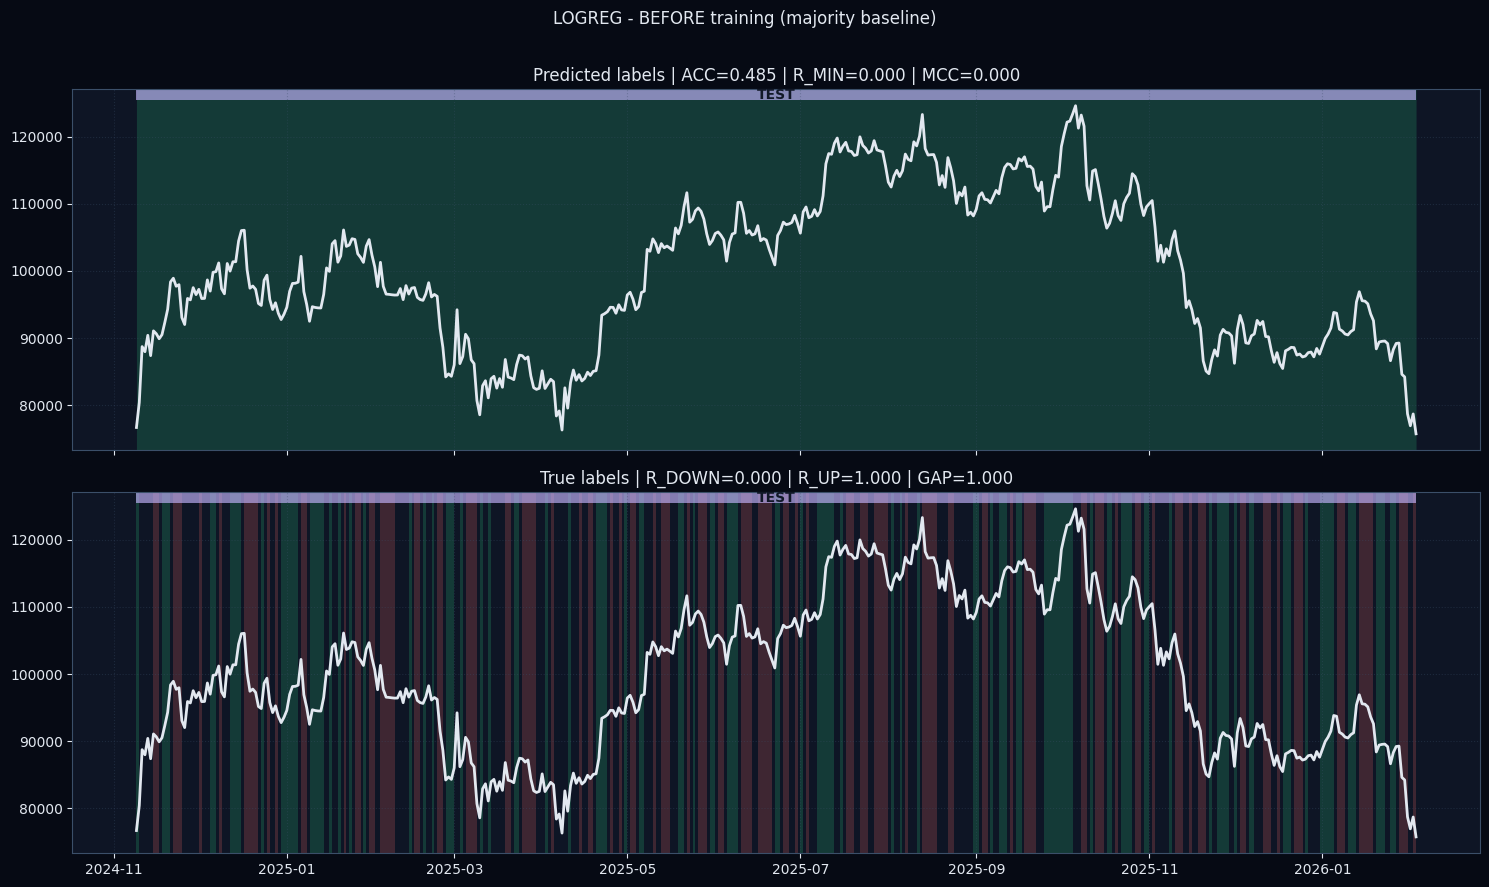

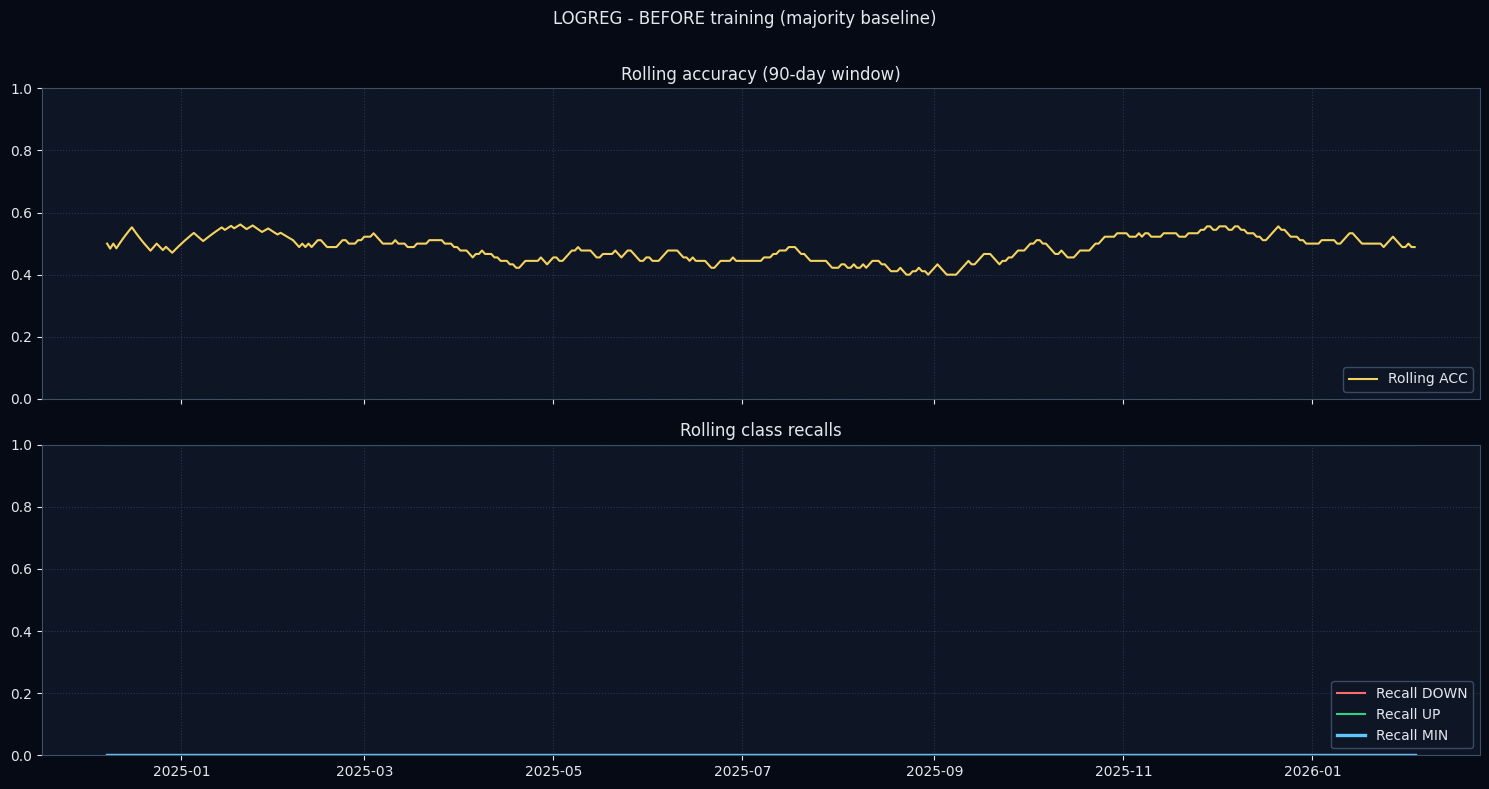

LOGREG - BEFORE training (majority baseline)
ACC=0.4845 | BAL_ACC=0.5000 | MCC=0.0000 | R_DOWN=0.0000 | R_UP=1.0000 | R_MIN=0.0000
Significance vs random(50%): p-value=0.759743, 95% CI for ACC=[0.4388, 0.5305]


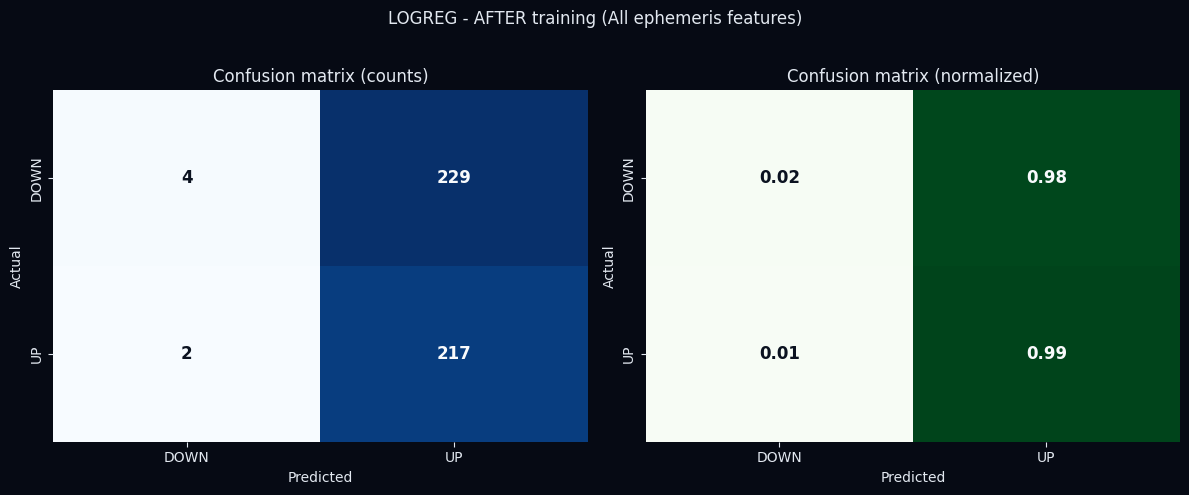

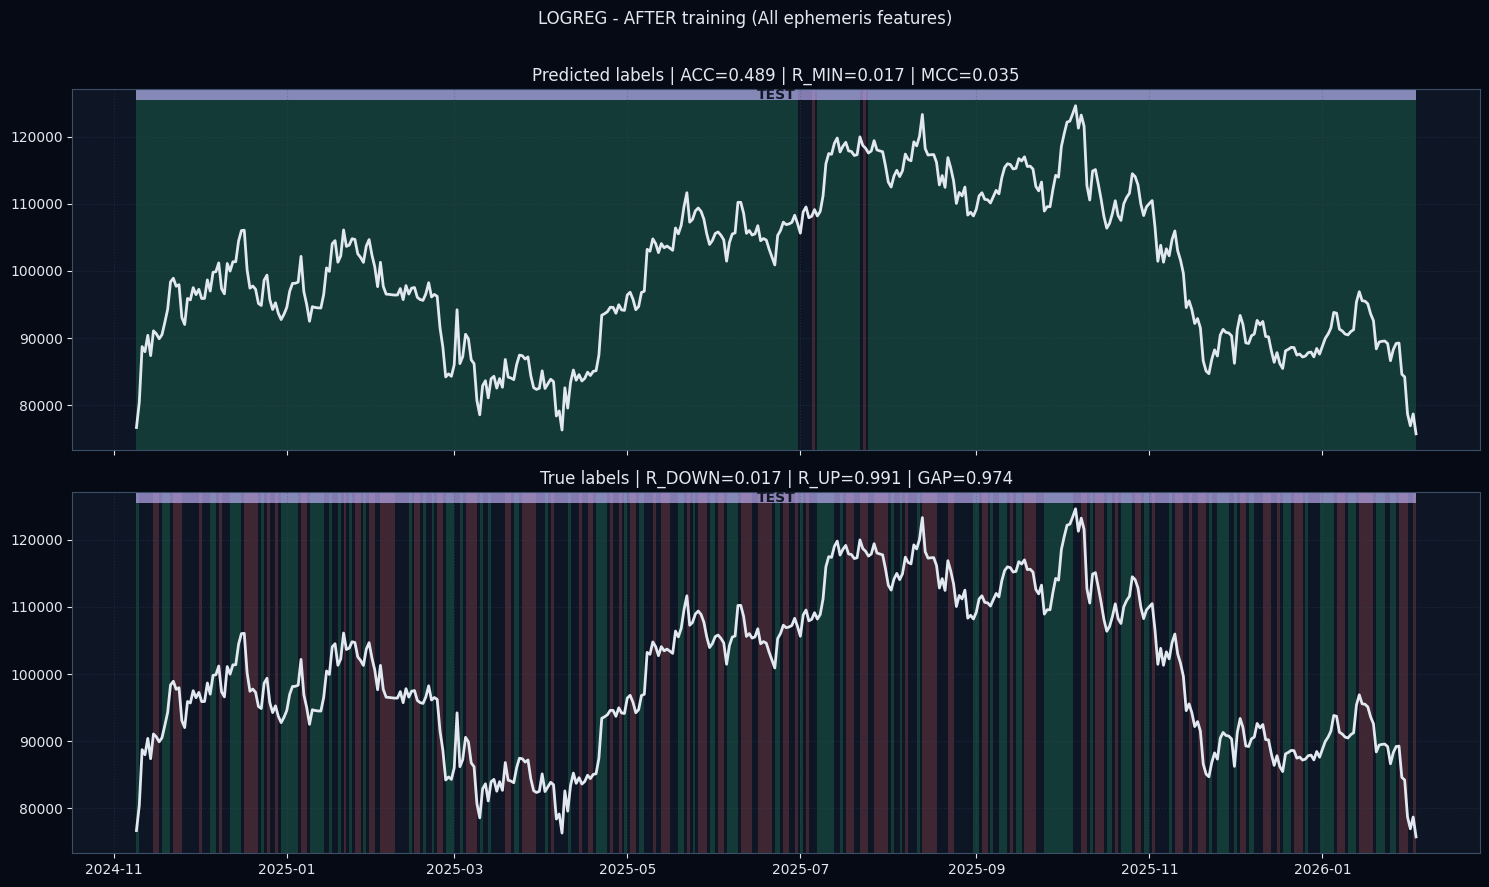

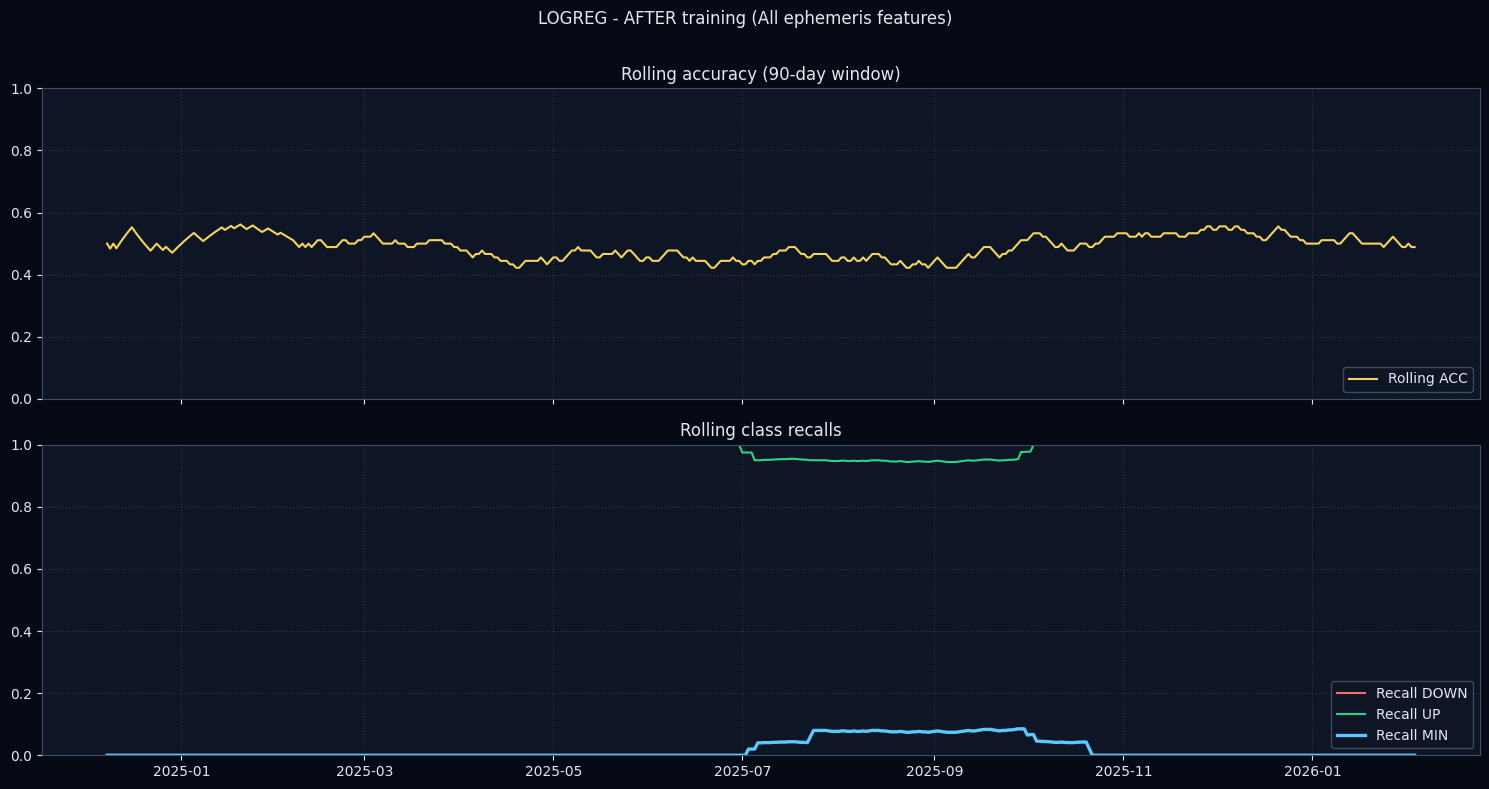

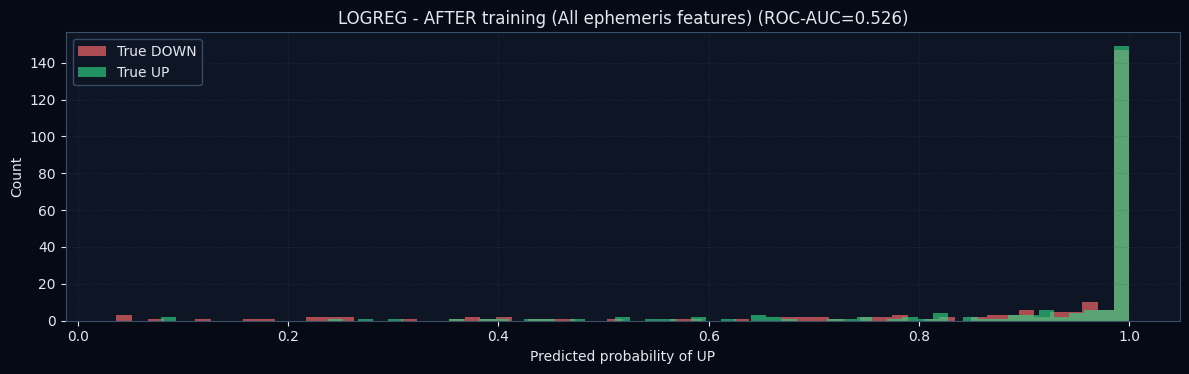

LOGREG - AFTER training (All ephemeris features)
ACC=0.4889 | BAL_ACC=0.5040 | MCC=0.0351 | R_DOWN=0.0172 | R_UP=0.9909 | R_MIN=0.0172
Significance vs random(50%): p-value=0.697536, 95% CI for ACC=[0.4431, 0.5349]

####################################################################################################
WINNER MODEL: mlp


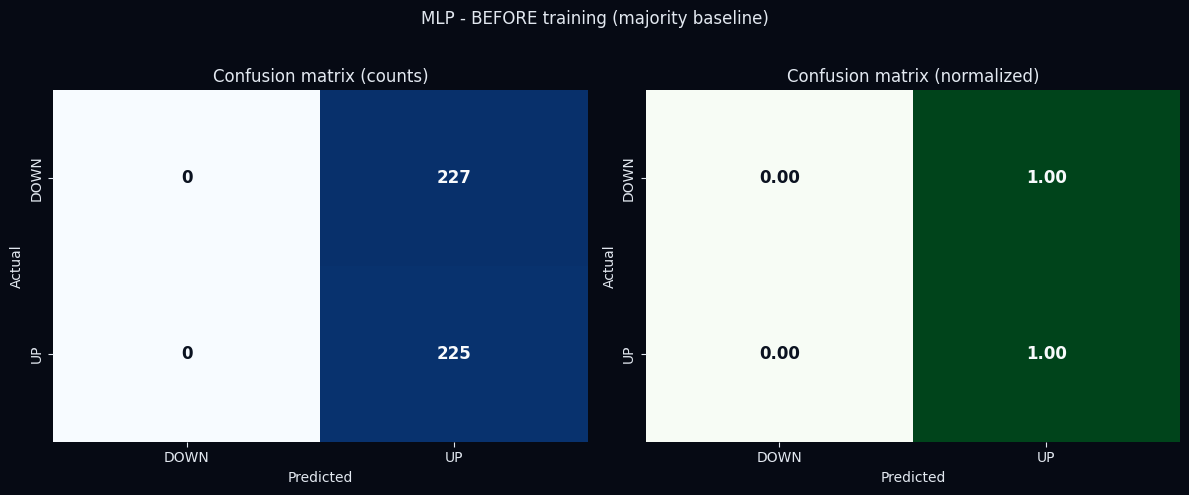

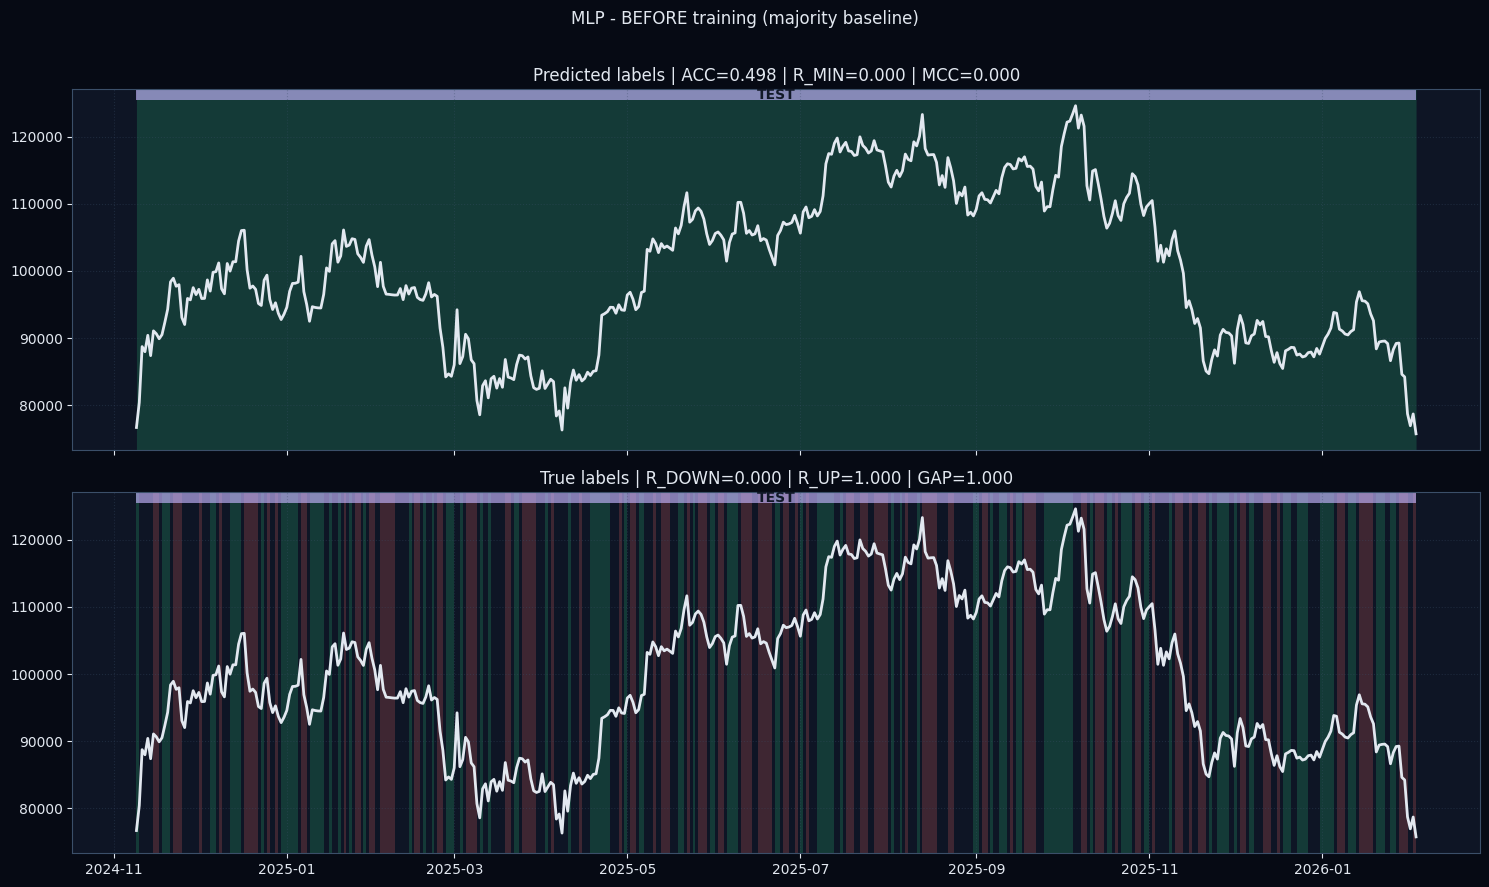

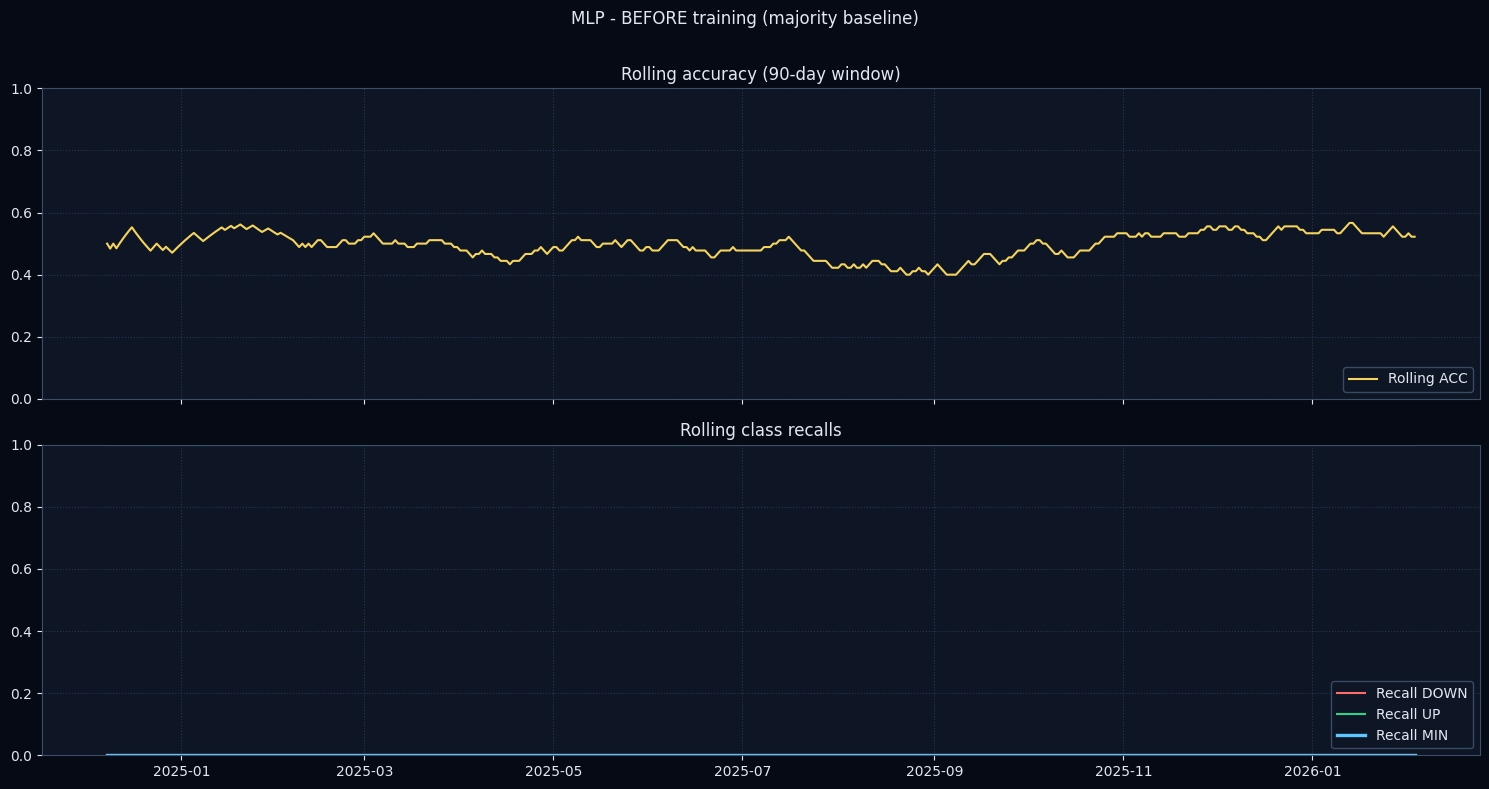

MLP - BEFORE training (majority baseline)
ACC=0.4978 | BAL_ACC=0.5000 | MCC=0.0000 | R_DOWN=0.0000 | R_UP=1.0000 | R_MIN=0.0000
Significance vs random(50%): p-value=0.556098, 95% CI for ACC=[0.4519, 0.5437]


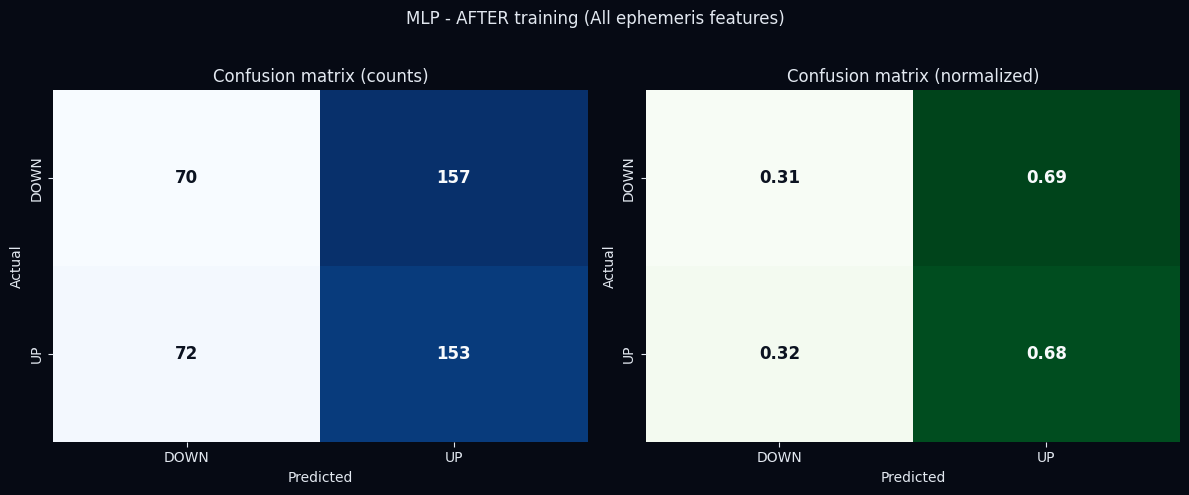

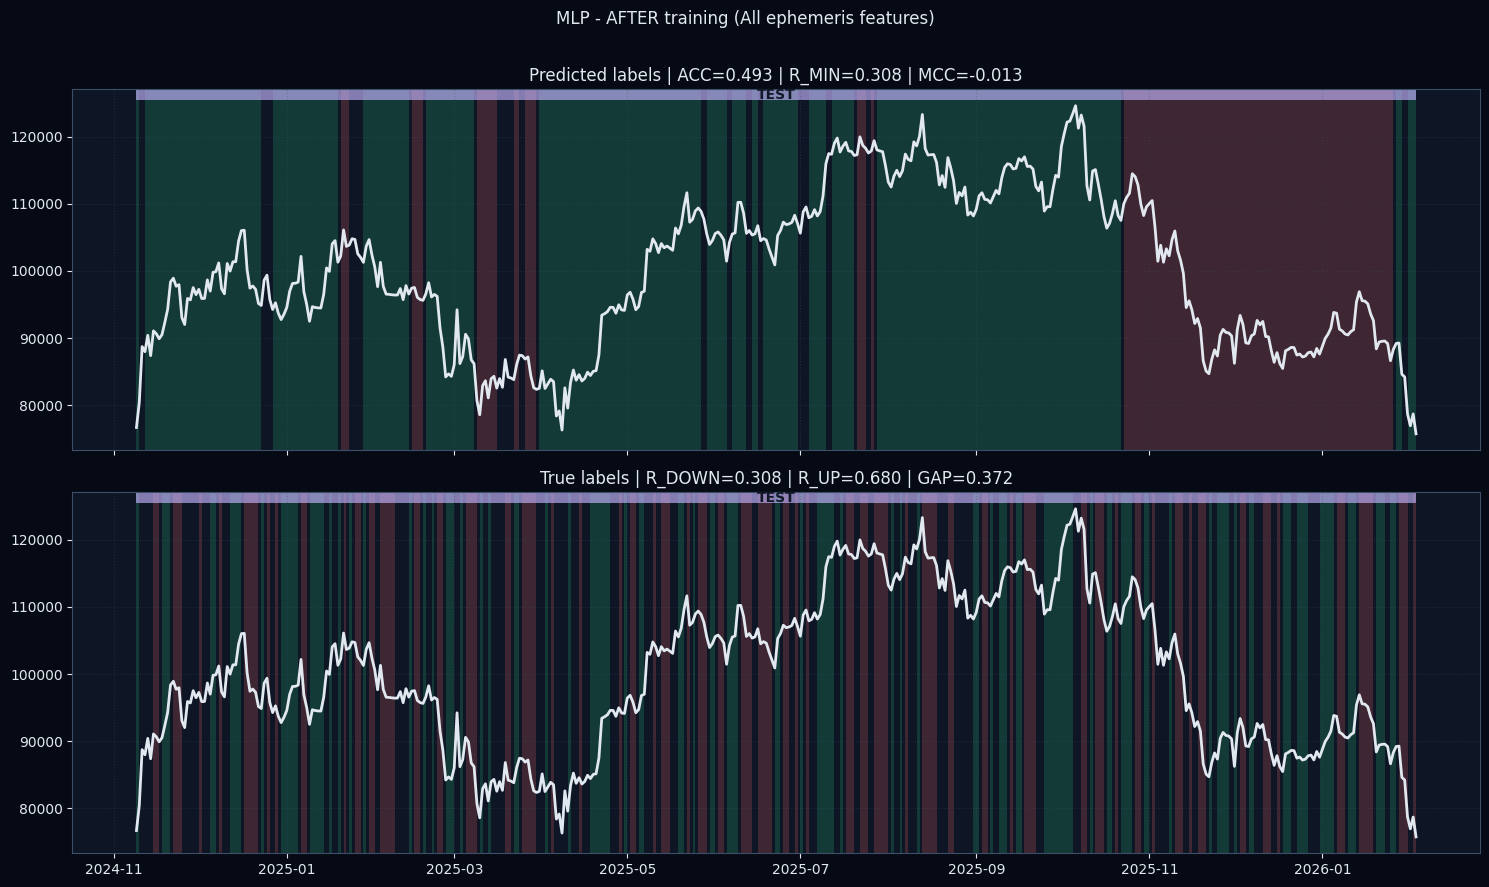

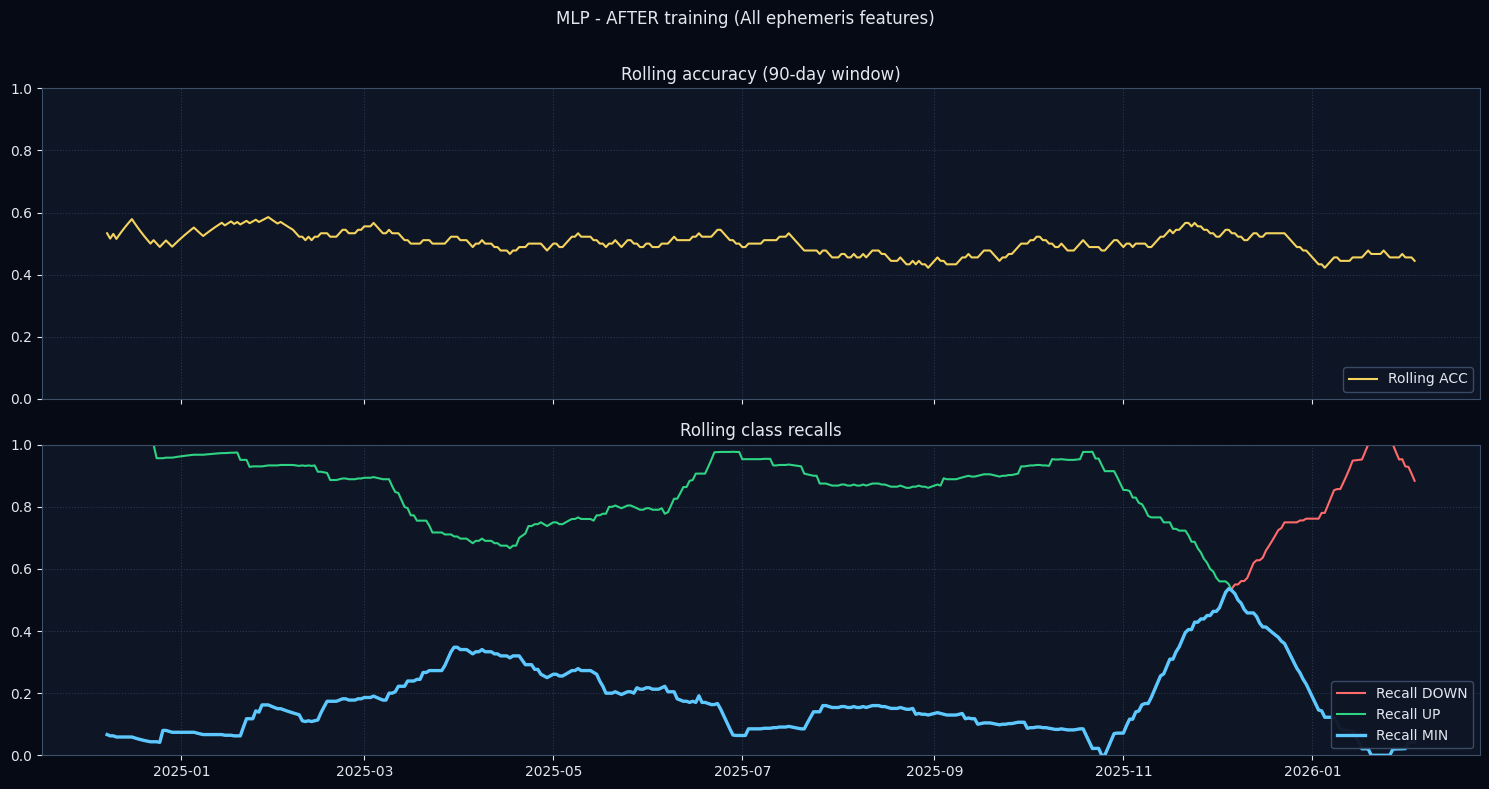

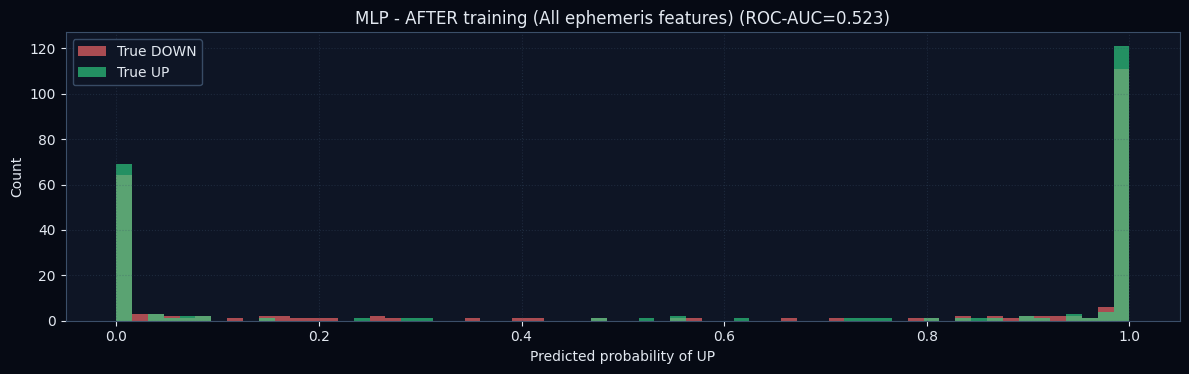

MLP - AFTER training (All ephemeris features)
ACC=0.4934 | BAL_ACC=0.4942 | MCC=-0.0125 | R_DOWN=0.3084 | R_UP=0.6800 | R_MIN=0.3084
Significance vs random(50%): p-value=0.628997, 95% CI for ACC=[0.4475, 0.5393]

####################################################################################################
WINNER MODEL: rf


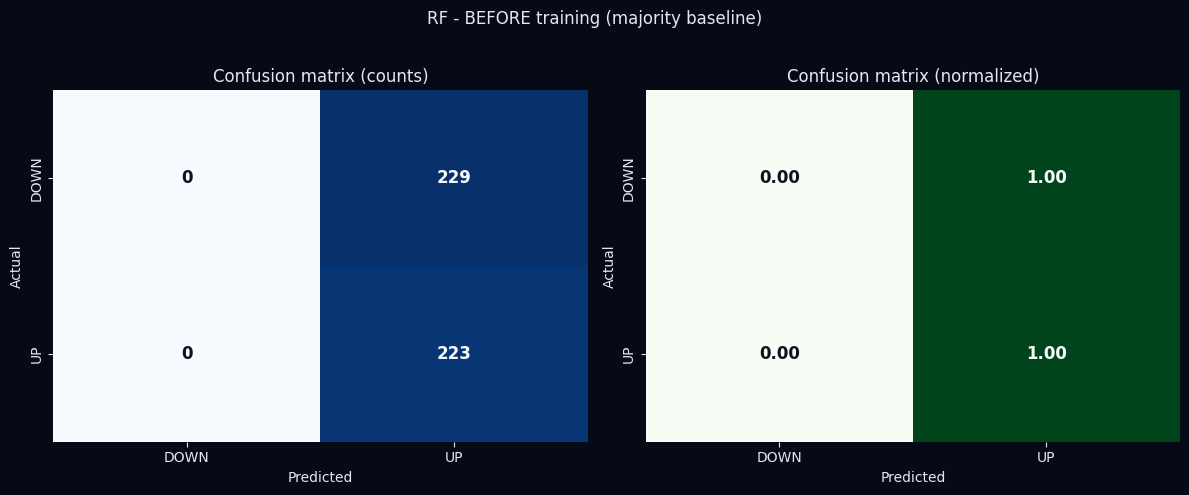

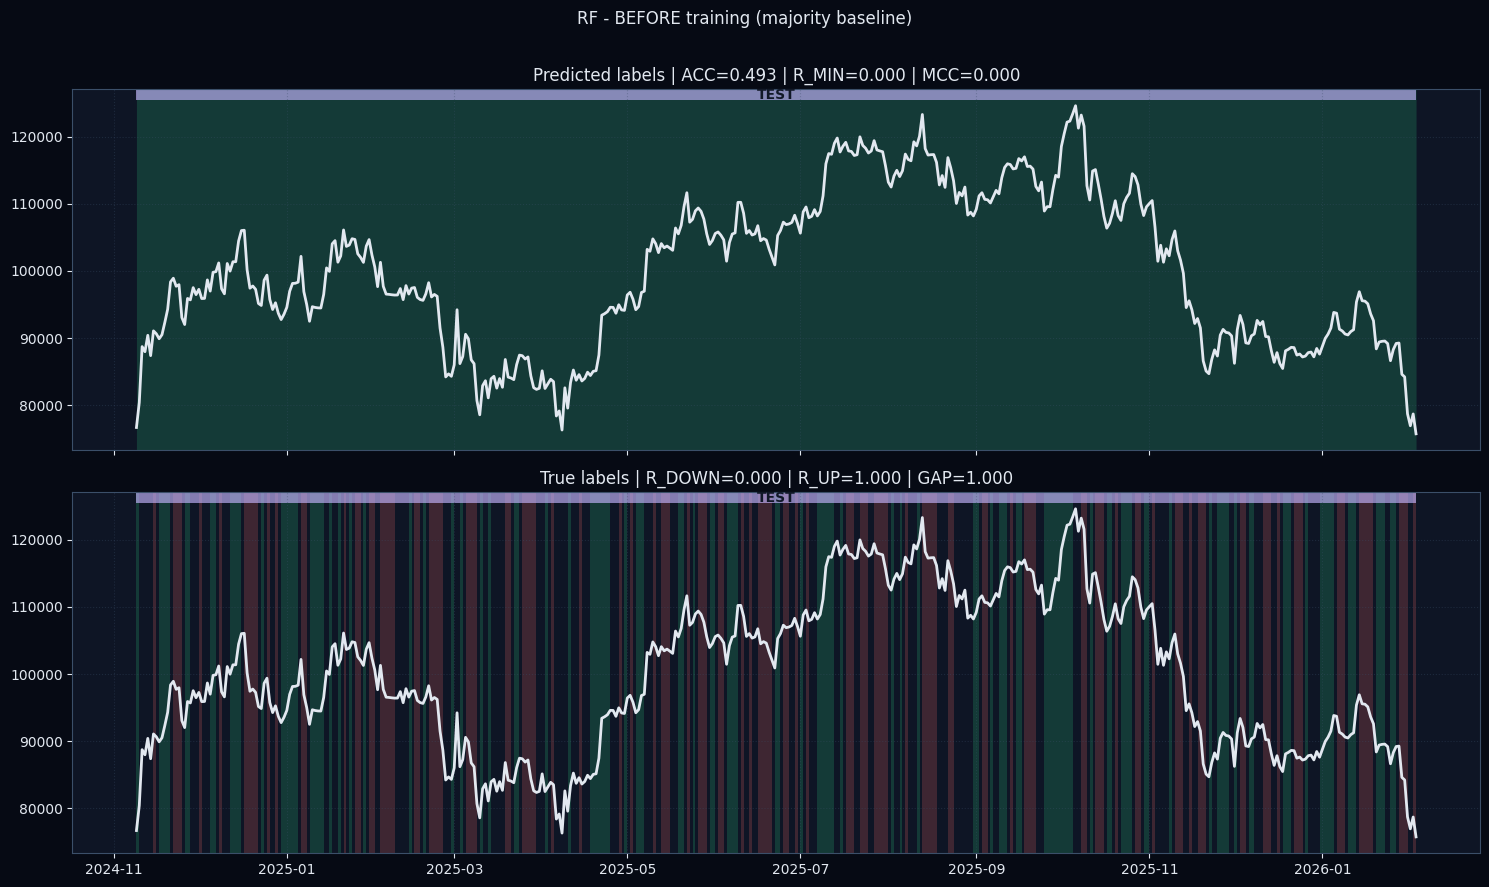

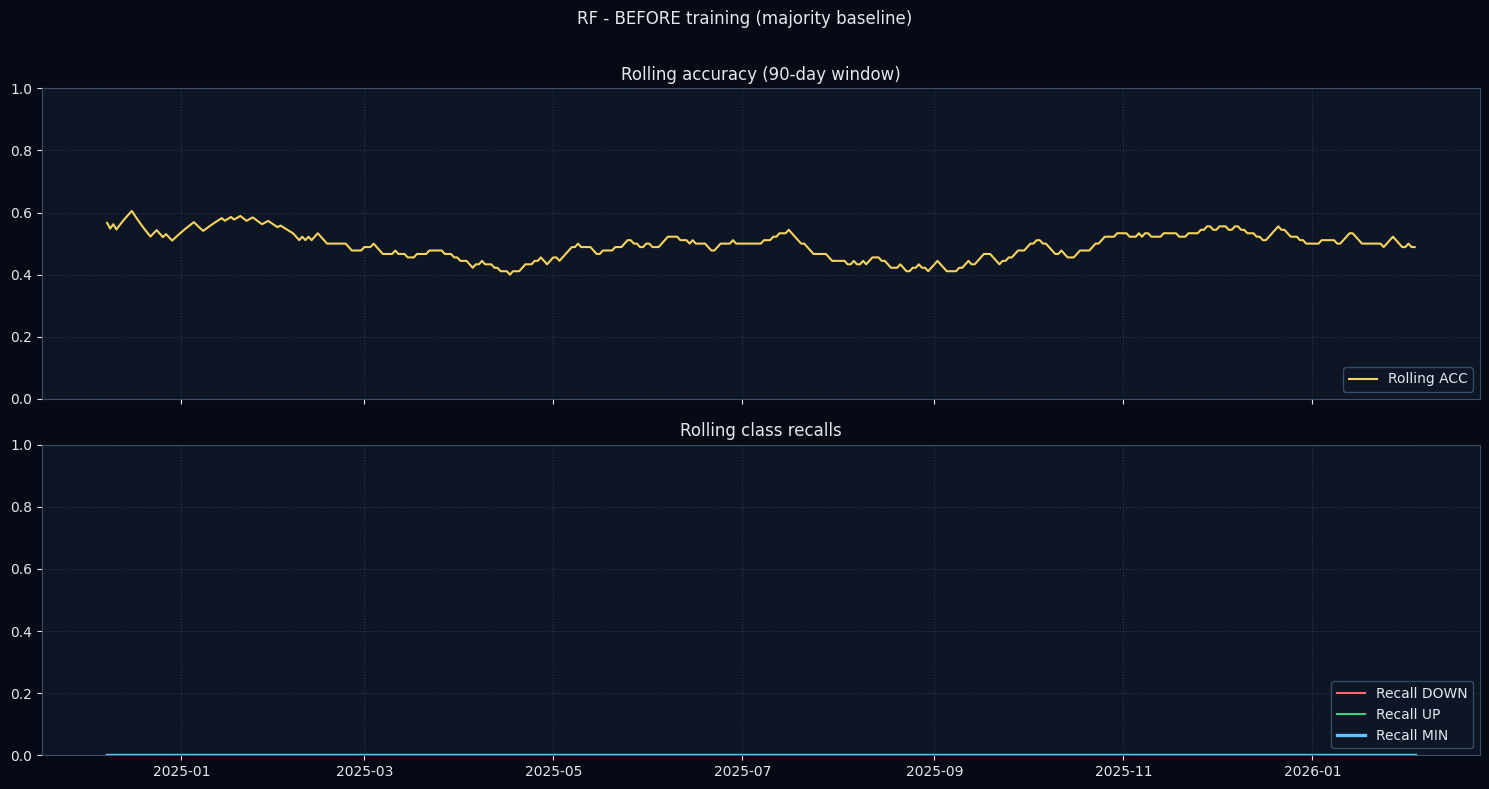

RF - BEFORE training (majority baseline)
ACC=0.4934 | BAL_ACC=0.5000 | MCC=0.0000 | R_DOWN=0.0000 | R_UP=1.0000 | R_MIN=0.0000
Significance vs random(50%): p-value=0.628997, 95% CI for ACC=[0.4475, 0.5393]


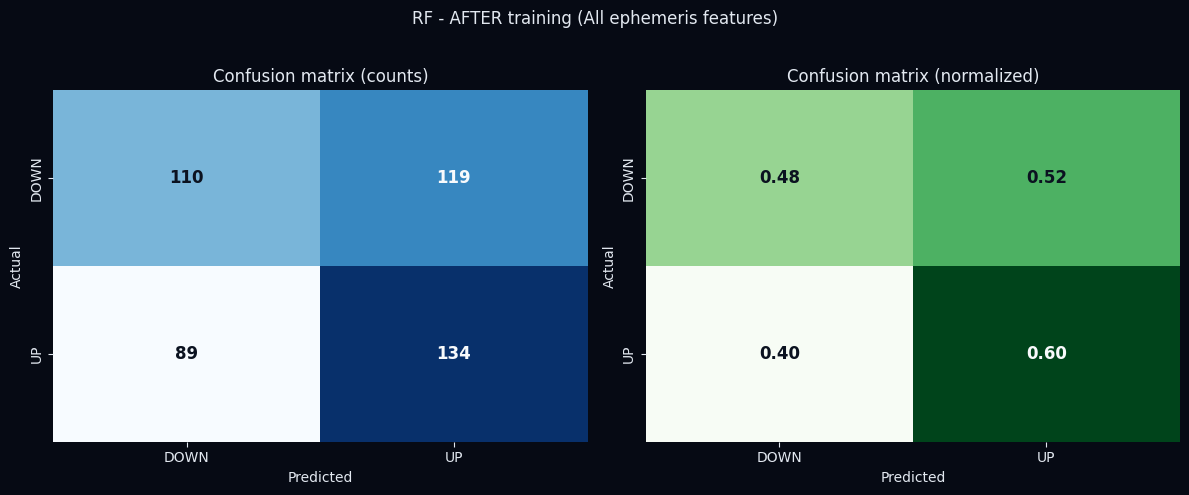

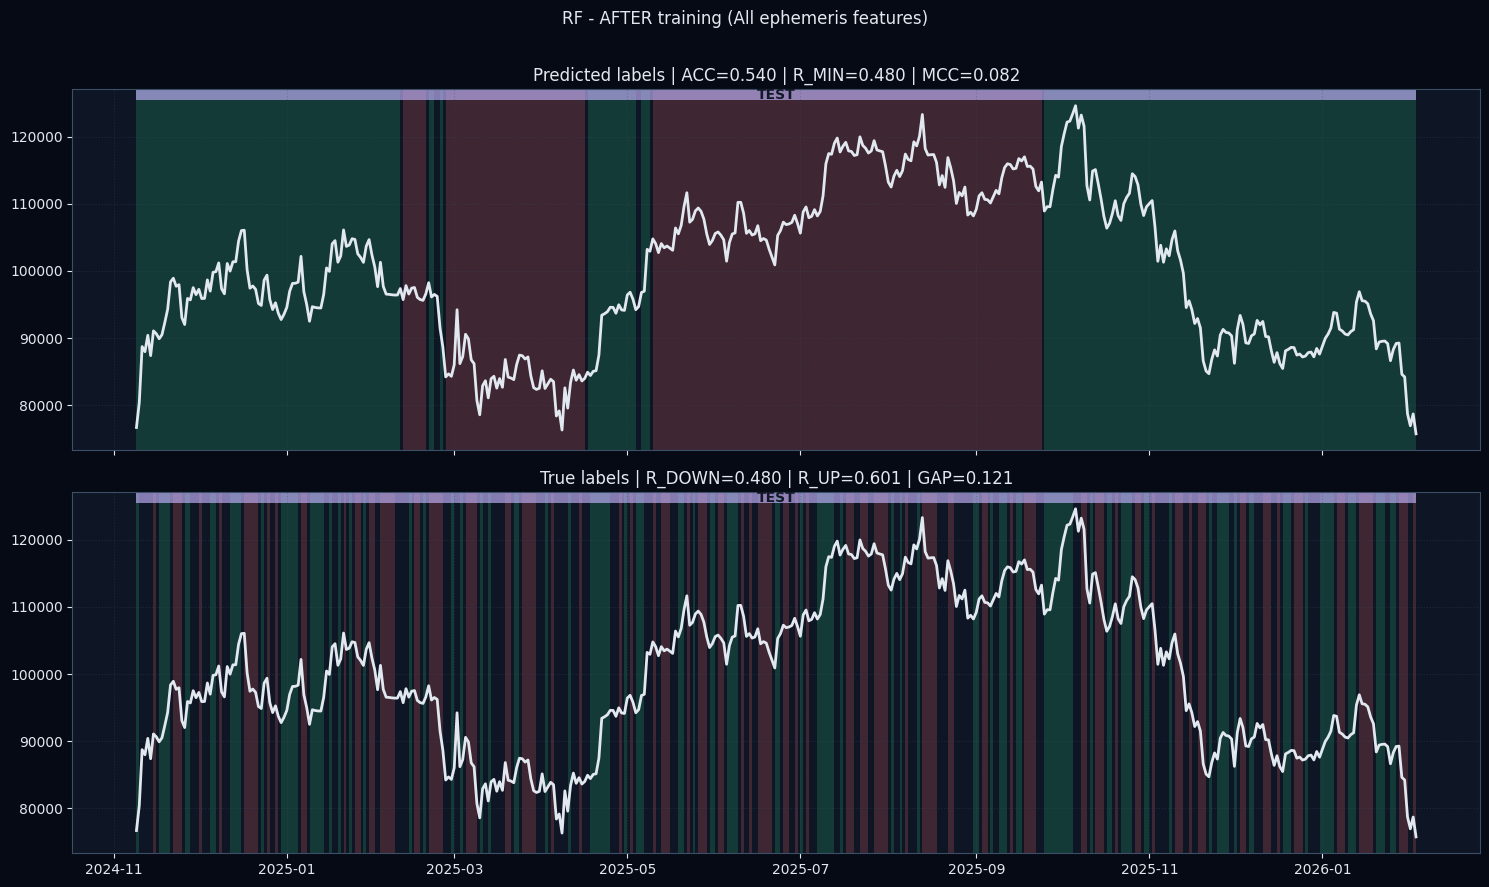

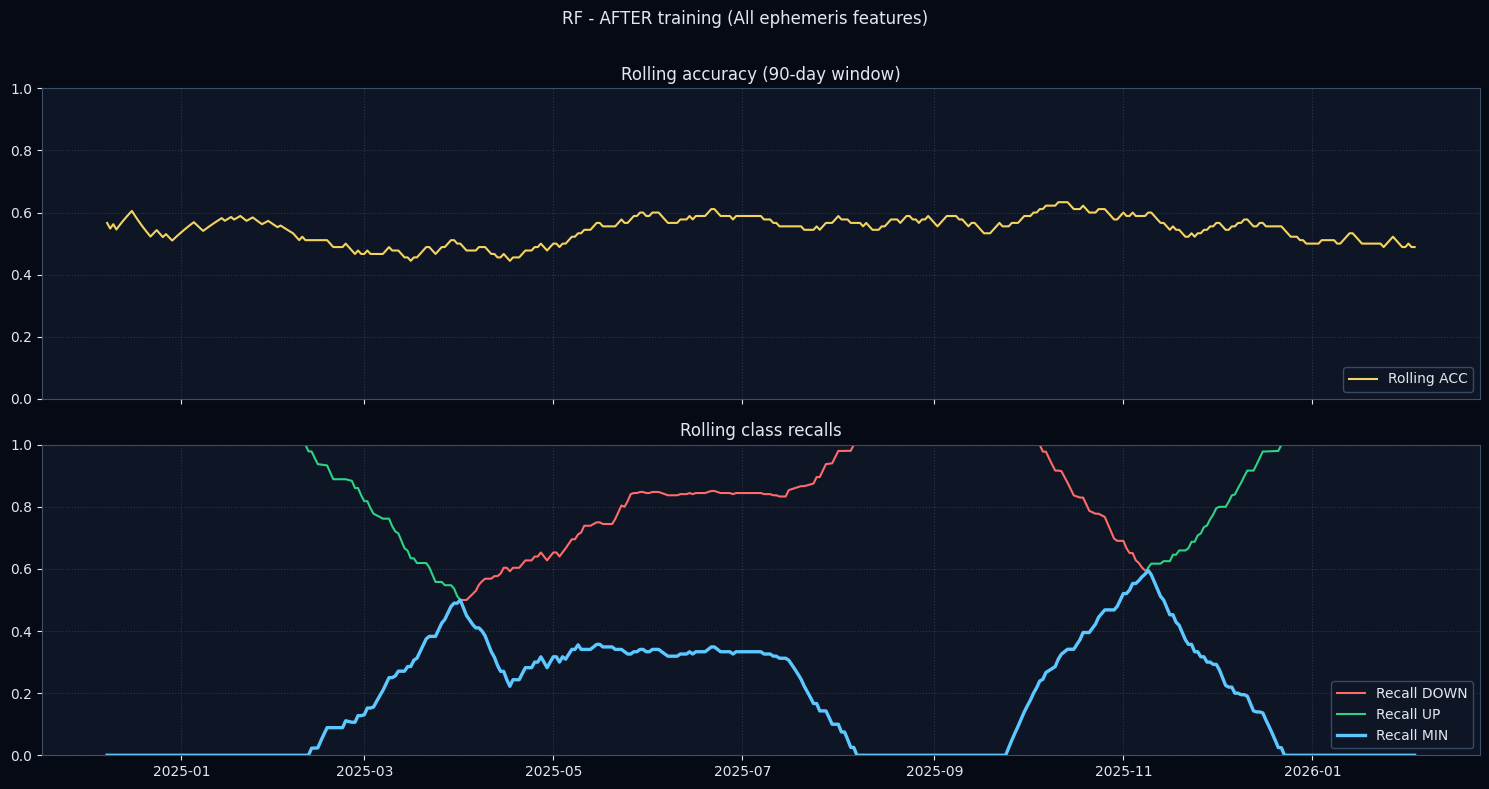

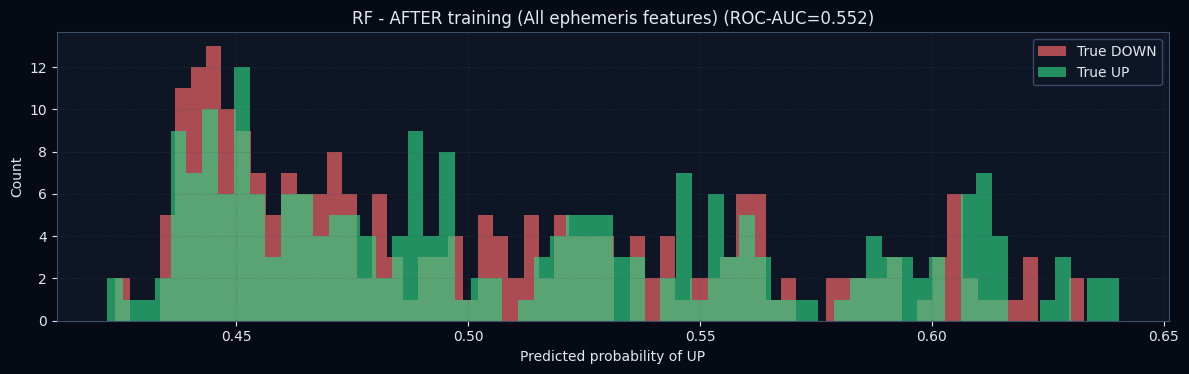

RF - AFTER training (All ephemeris features)
ACC=0.5398 | BAL_ACC=0.5406 | MCC=0.0818 | R_DOWN=0.4803 | R_UP=0.6009 | R_MIN=0.4803
Significance vs random(50%): p-value=0.0498015, 95% CI for ACC=[0.4937, 0.5852]

####################################################################################################
WINNER MODEL: xgb


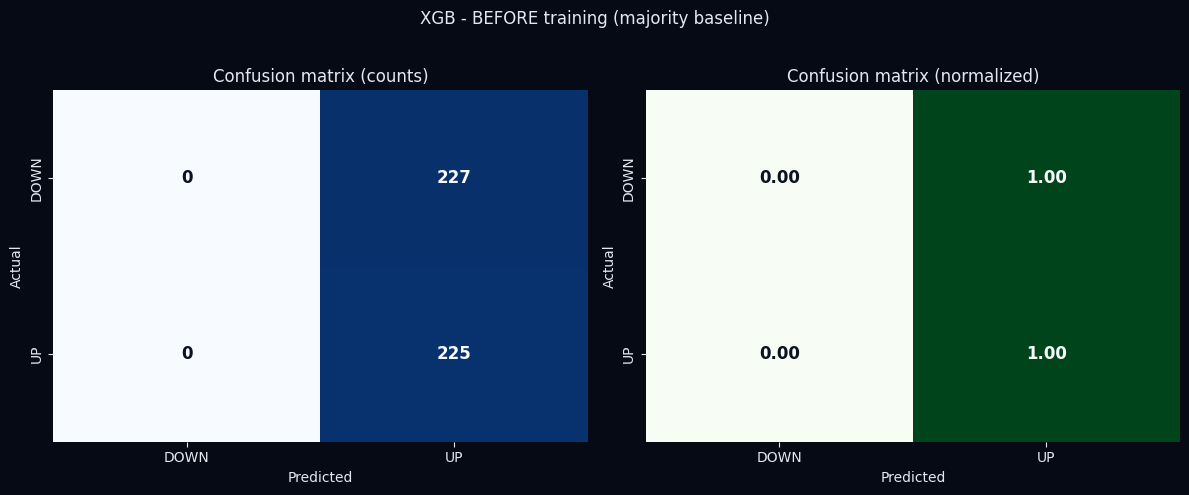

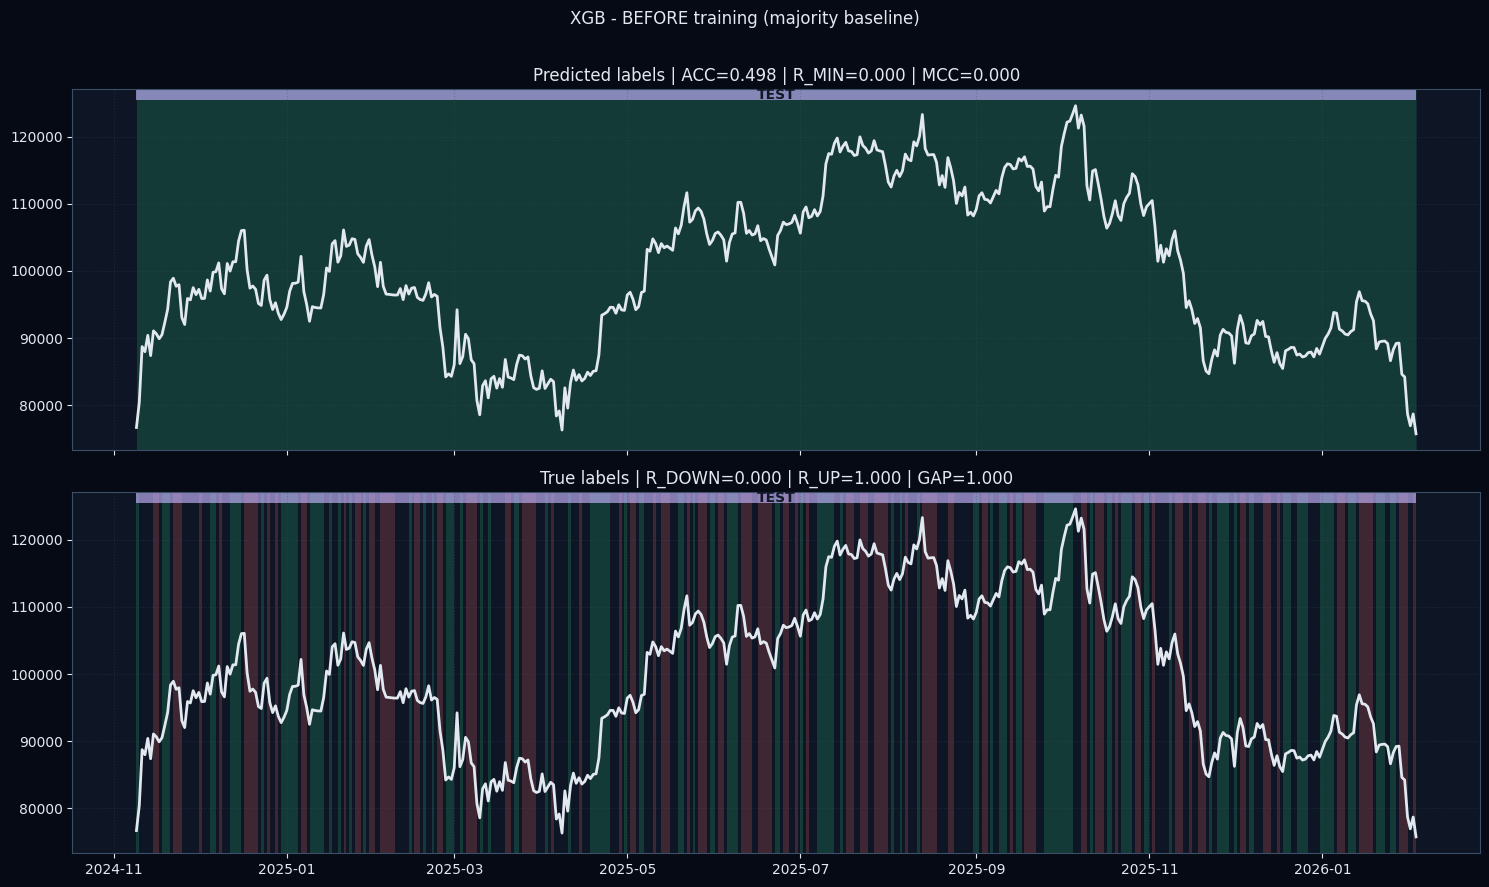

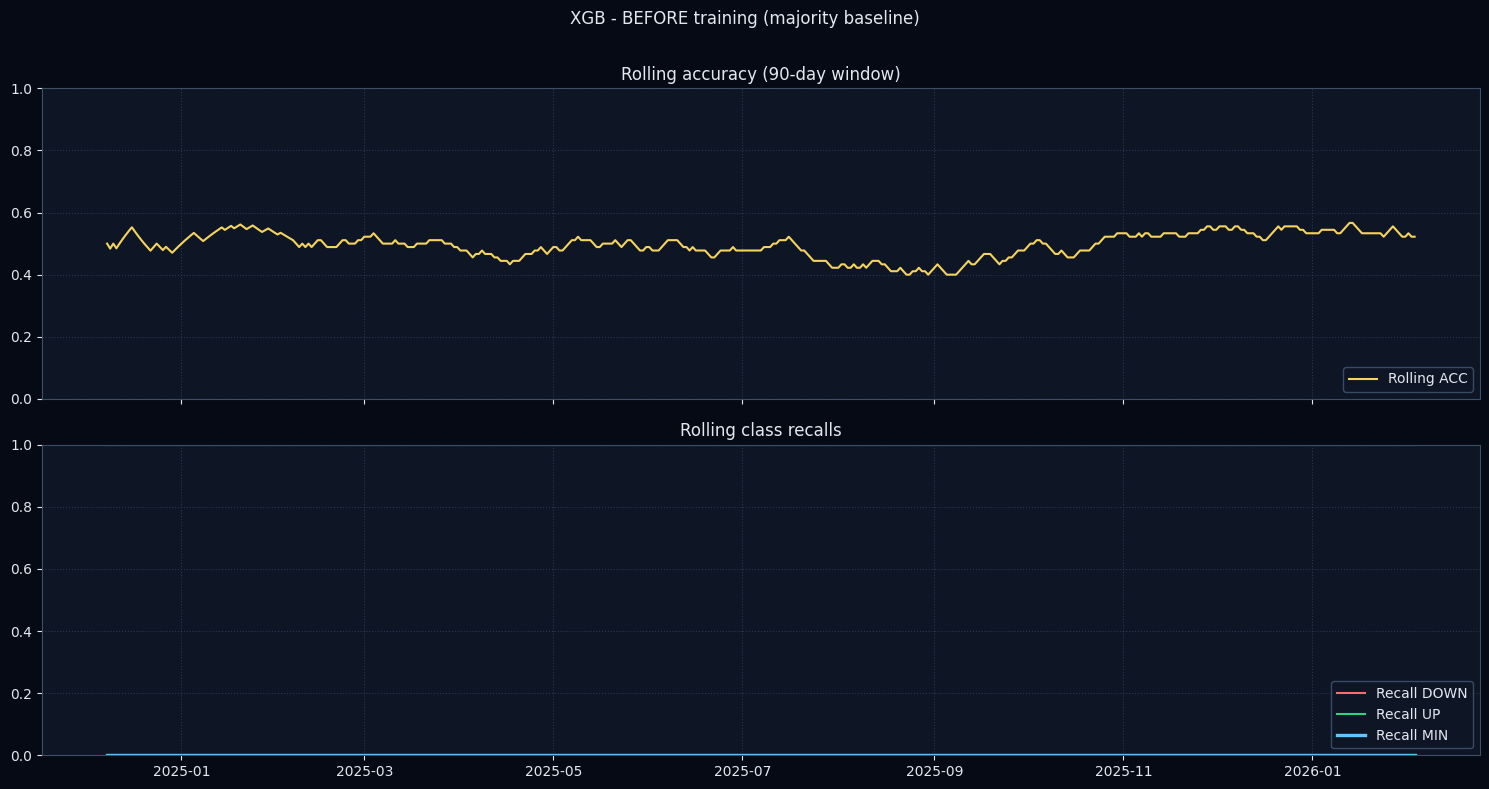

XGB - BEFORE training (majority baseline)
ACC=0.4978 | BAL_ACC=0.5000 | MCC=0.0000 | R_DOWN=0.0000 | R_UP=1.0000 | R_MIN=0.0000
Significance vs random(50%): p-value=0.556098, 95% CI for ACC=[0.4519, 0.5437]


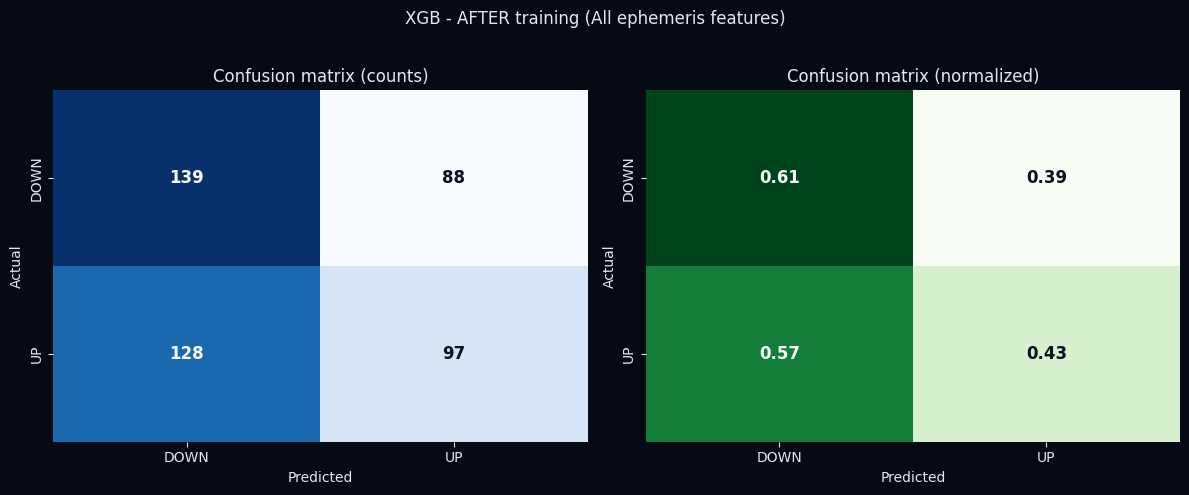

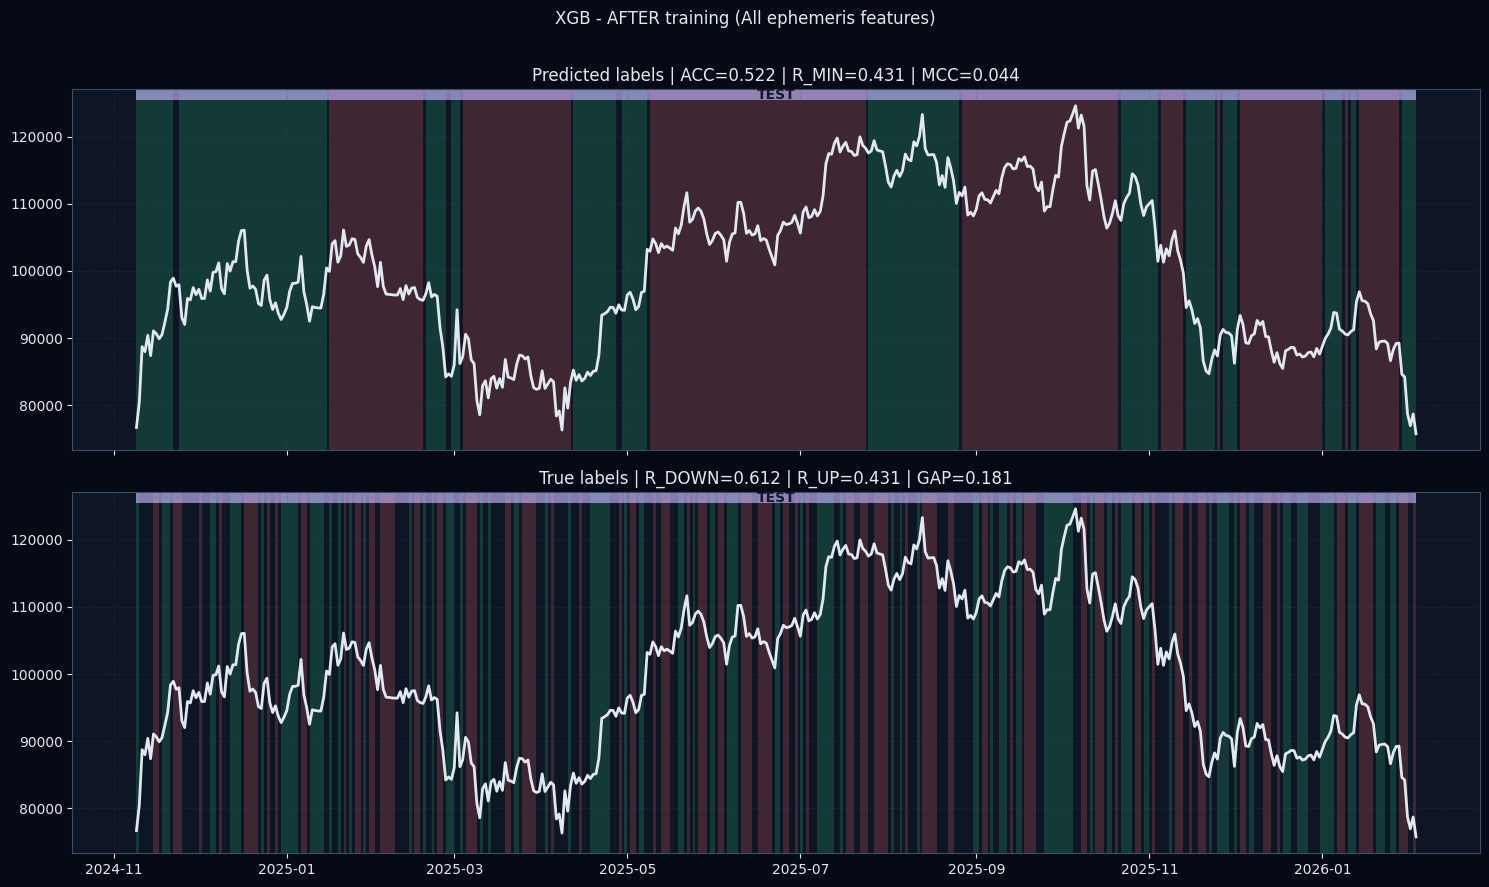

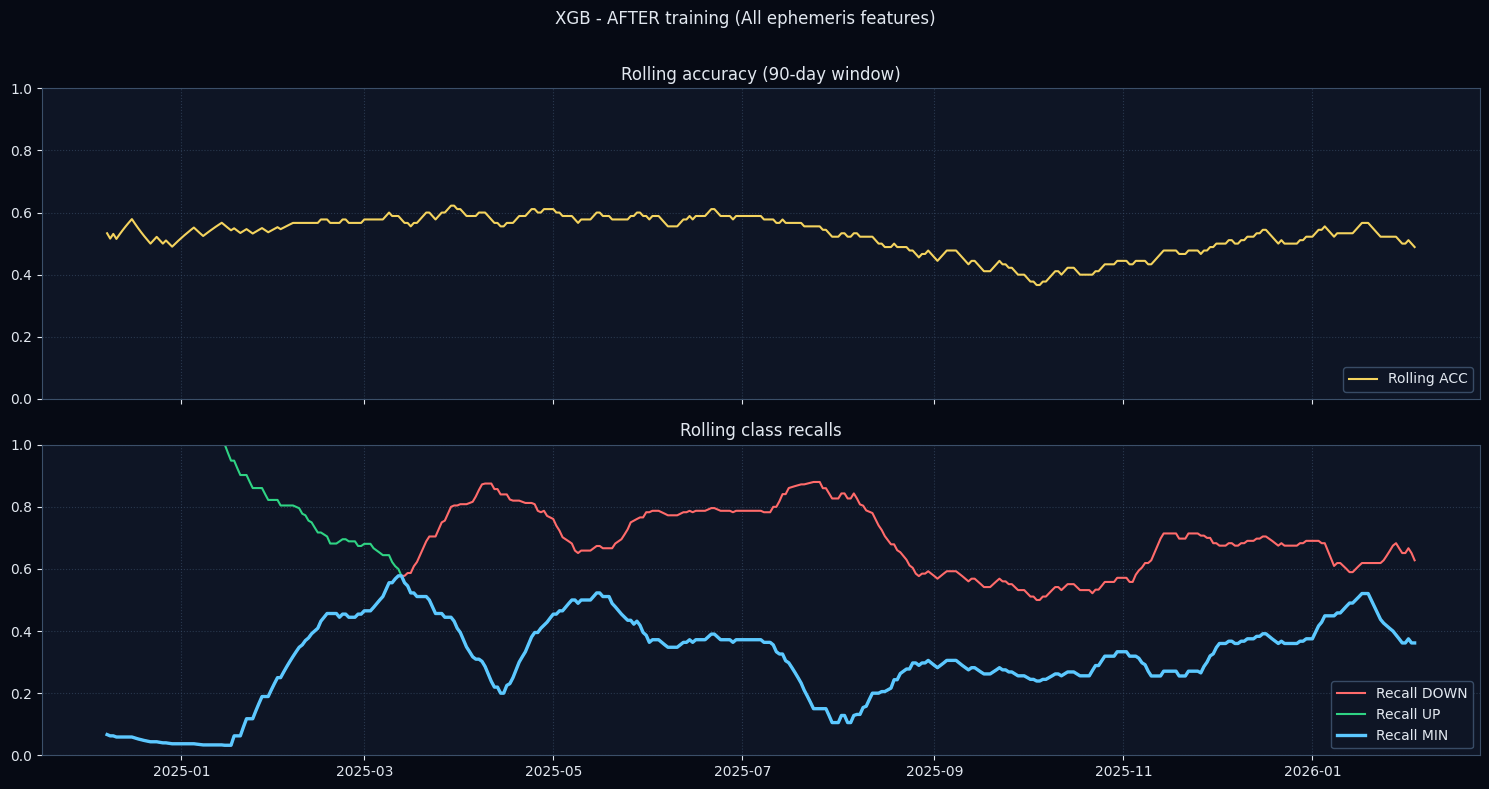

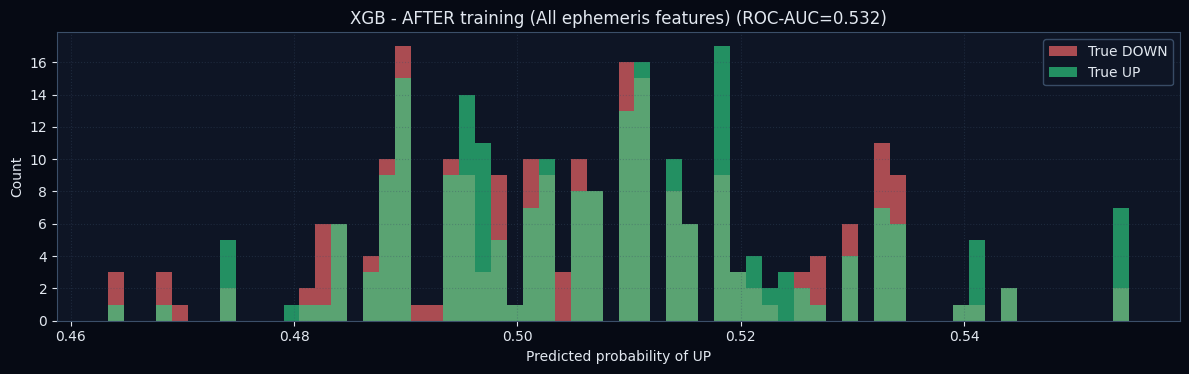

XGB - AFTER training (All ephemeris features)
ACC=0.5221 | BAL_ACC=0.5217 | MCC=0.0442 | R_DOWN=0.6123 | R_UP=0.4311 | R_MIN=0.4311
Significance vs random(50%): p-value=0.185754, 95% CI for ACC=[0.4761, 0.5678]


In [7]:
for model_name, run in best_runs.items():
    print()
    print('#' * 100)
    print('WINNER MODEL:', model_name)

    pred = run['predictions'].copy()
    test_df = pred[pred['split_role'] == 'test'].copy().reset_index(drop=True)
    test_df = test_df.dropna(subset=['pred_label'])

    # Evaluate baseline (majority) vs model on the SAME test period.
    _ = evaluate_with_visuals(
        df_plot=test_df,
        y_true=test_df['target'].to_numpy(dtype=np.int32),
        y_pred=test_df['baseline_majority'].to_numpy(dtype=np.int32),
        y_prob_up=None,
        title=f"{model_name.upper()} - BEFORE training (majority baseline)",
        vis_cfg=VIS_CFG,
        show_visuals=True,
    )

    _ = evaluate_with_visuals(
        df_plot=test_df,
        y_true=test_df['target'].to_numpy(dtype=np.int32),
        y_pred=test_df['pred_label'].to_numpy(dtype=np.int32),
        y_prob_up=test_df['pred_proba_up'].to_numpy(dtype=float),
        title=f"{model_name.upper()} - AFTER training ({FEATURE_LABEL})",
        vis_cfg=VIS_CFG,
        show_visuals=True,
    )

In [8]:
# -------------------------------------------------
# Quick conclusion helper
# -------------------------------------------------
# This is a simple text summary you can read like a report.

report_cols = [
    'model',
    'gauss_window',
    'gauss_std',
    'val_recall_min',
    'val_recall_gap',
    'val_mcc',
    'test_recall_min',
    'test_recall_gap',
    'test_mcc',
    'test_acc',
    'accuracy_ci95_low',
    'accuracy_ci95_high',
    'p_value_vs_random',
]

display(best_by_val[report_cols])

print()
print('Interpretation guide (very simple):')
print('- If test_acc CI includes 0.50 and p-value is not small (e.g. > 0.05), it looks like random.')
print('- If test_recall_min is below 0.50, the weaker class is basically not predictable.')
print('- If MCC is near 0, it is basically random.')

model  gauss_window  gauss_std  val_recall_min  val_recall_gap   val_mcc  test_recall_min  test_recall_gap  test_mcc  test_acc  accuracy_ci95_low  \
0      rf           401       90.0        0.485597        0.088566  0.059802         0.480349         0.120548  0.081825  0.539823           0.493731   
1     xgb           201       40.0        0.539419        0.000865  0.079528         0.431111         0.181224  0.044179  0.522124           0.476081   
2     mlp           201       40.0        0.497630        0.000295 -0.004435         0.308370         0.371630 -0.012527  0.493363           0.447522   
3  logreg           151       20.0        0.523364        0.006047  0.052704         0.017167         0.973700  0.035087  0.488938           0.443142   

   accuracy_ci95_high  p_value_vs_random  
0            0.585243           0.049802  
1            0.567794           0.185754  
2            0.539315           0.628997  
3            0.534921           0.697536


Interpretation guide (very simple):
- If test_acc CI includes 0.50 and p-value is not small (e.g. > 0.05), it looks like random.
- If test_recall_min is below 0.50, the weaker class is basically not predictable.
- If MCC is near 0, it is basically random.


In [22]:
best_by_val

model  threshold  val_score   val_acc   val_mcc  val_recall_min  val_recall_gap  test_acc  test_bal_acc  test_mcc  test_recall_min  test_recall_gap  \
0      rf       0.48   0.459473  0.526549  0.059802        0.485597        0.088566  0.539823      0.540623  0.081825         0.480349         0.120548   
1     xgb       0.51   0.537654  0.539823  0.079528        0.539419        0.000865  0.522124      0.521723  0.044179         0.431111         0.181224   
2     mlp       0.05   0.495897  0.497788 -0.004435        0.497630        0.000295  0.493363      0.494185 -0.012527         0.308370         0.371630   
3  logreg       0.10   0.520746  0.526549  0.052704        0.523364        0.006047  0.488938      0.504017  0.035087         0.017167         0.973700   

   p_value_vs_random  accuracy_ci95_low  accuracy_ci95_high  baseline_majority_test_acc  baseline_random_test_acc  test_up_share  pred_up_share  gauss_window  \
0           0.049802           0.493731            0.585243                    0.493363                  0.471239       0.493363       0.559735           401   
1           0.185754           0.476081            0.567794                    0.497788                  0.462389       0.497788       0.409292           201   
2           0.628997           0.447522            0.539315                    0.497788                  0.462389       0.497788       0.685841           201   
3           0.697536           0.443142            0.534921                    0.484513                  0.464602       0.484513       0.986726           151   

   gauss_std  
0       90.0  
1       40.0  
2       40.0  
3       20.0

## Trading sanity-check (very simple)

This section answers a very practical question:

- If we blindly **buy when the model says UP** and **sell when it says DOWN**,
  does the equity curve look better than Buy&Hold *on the same test period*?

We keep the trading model intentionally simple because the goal is research clarity, not perfection:
- 0.1% fee per buy and per sell (configurable)
- optional stop-loss (approximation with daily close only)
- optional 'no-signal' neutral zone based on probability thresholds

If even this simple test looks random, it is a strong sign that Moon-only features have no edge.



####################################################################################################
TRADING CHECK FOR MODEL: logreg
Base trading metrics: {'final_equity': 0.9724192575397096, 'hold_final_equity': 0.9857308426386139, 'return_pct': -0.02758074246029041, 'hold_return_pct': -0.01426915736138612, 'excess_return_pct': -0.013504279792312945, 'num_trades': 5, 'winrate': 0.8, 'max_drawdown_pct': 39.29424842632304, 'ulcer_index': 15.502611925882908, 'exposure_pct': 98.45132743362832, 'ulcer_adjusted_return': -0.0017791029403401405}


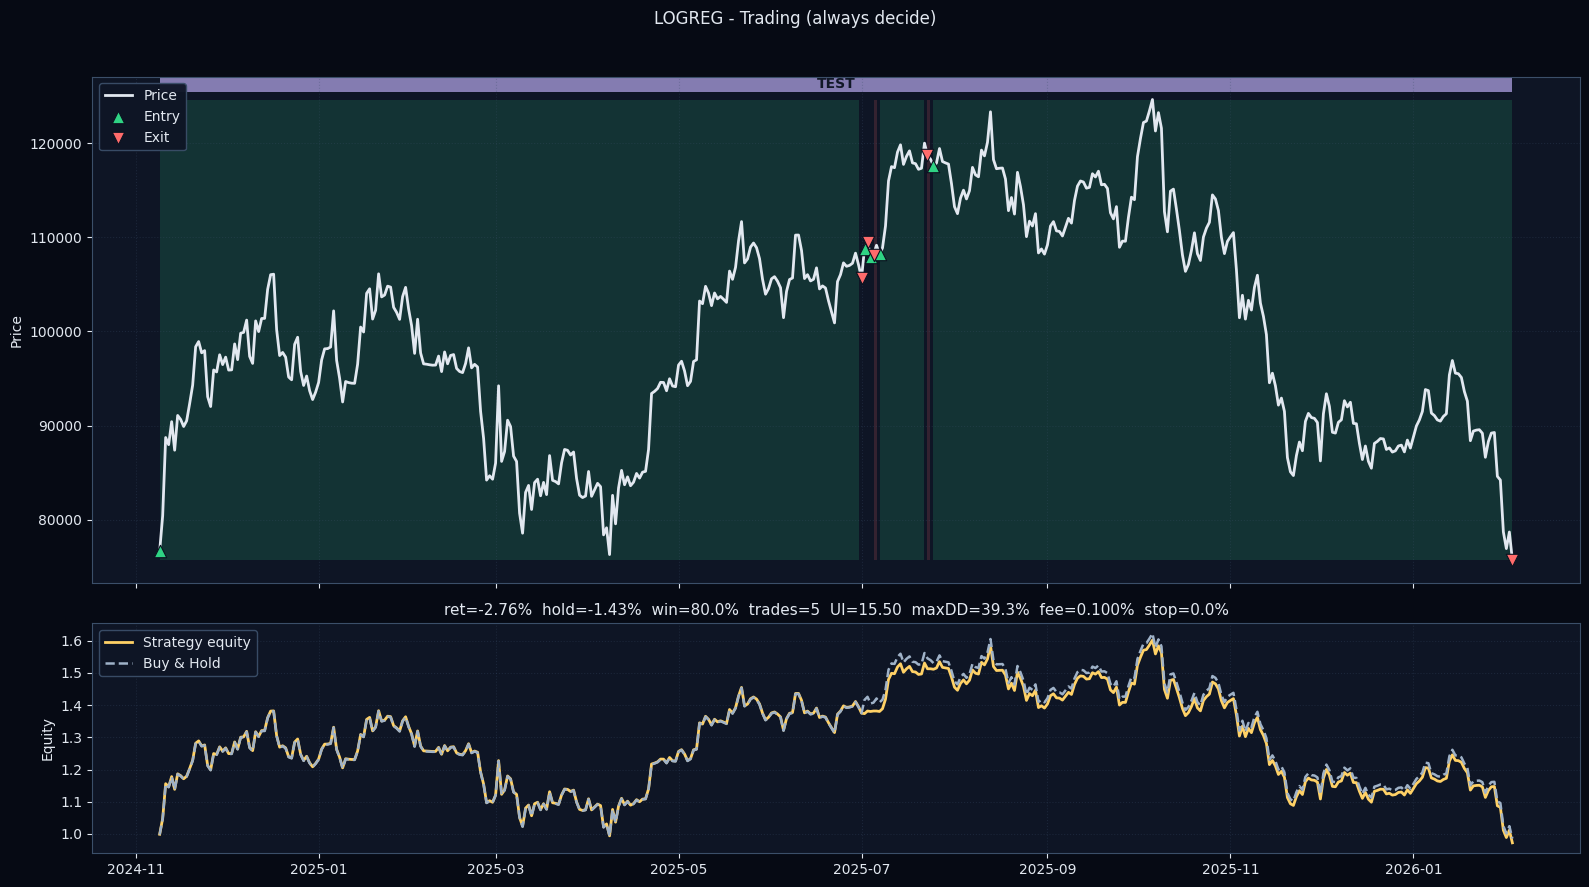

[sweep 1/8] left=7 stop=0.000 exit_no_sig=False | ret=1.821% UI=15.49 win=69.2% | BEST score=0.00118
[sweep 2/8] left=6 stop=0.000 exit_no_sig=True | ret=1.821% UI=15.49 win=69.2% | BEST score=0.00118
[sweep 3/8] left=5 stop=0.020 exit_no_sig=False | ret=-5.269% UI=16.15 win=32.1% | BEST score=0.00118
[sweep 4/8] left=4 stop=0.020 exit_no_sig=True | ret=-5.269% UI=16.15 win=32.1% | BEST score=0.00118
[sweep 5/8] left=3 stop=0.050 exit_no_sig=False | ret=-1.807% UI=16.59 win=42.9% | BEST score=0.00118
[sweep 6/8] left=2 stop=0.050 exit_no_sig=True | ret=-1.807% UI=16.59 win=42.9% | BEST score=0.00118
[sweep 7/8] left=1 stop=0.080 exit_no_sig=False | ret=-3.438% UI=15.03 win=47.4% | BEST score=0.00118
[sweep 8/8] left=0 stop=0.080 exit_no_sig=True | ret=-3.438% UI=15.03 win=47.4% | BEST score=0.00118


final_equity  hold_final_equity  return_pct  hold_return_pct  excess_return_pct  num_trades   winrate  max_drawdown_pct  ulcer_index  exposure_pct  \
0      1.018207           0.985731    0.018207        -0.014269           0.032946          13  0.692308         39.294248    15.485032     92.256637   
1      1.018207           0.985731    0.018207        -0.014269           0.032946          13  0.692308         39.294248    15.485032     92.256637   
2      0.981930           0.985731   -0.018070        -0.014269          -0.003856          21  0.428571         40.250016    16.591003     90.486726   
3      0.981930           0.985731   -0.018070        -0.014269          -0.003856          21  0.428571         40.250016    16.591003     90.486726   
4      0.965624           0.985731   -0.034376        -0.014269          -0.020398          19  0.473684         36.931911    15.027748     90.929204   
5      0.965624           0.985731   -0.034376        -0.014269          -0.020398          19  0.473684         36.931911    15.027748     90.929204   
6      0.947306           0.985731   -0.052694        -0.014269          -0.038981          28  0.321429         39.234768    16.153682     88.716814   
7      0.947306           0.985731   -0.052694        -0.014269          -0.038981          28  0.321429         39.234768    16.153682     88.716814   

   ulcer_adjusted_return  stop_loss_pct  exit_on_no_signal  
0               0.001176           0.00              False  
1               0.001176           0.00               True  
2              -0.001089           0.05              False  
3              -0.001089           0.05               True  
4              -0.002288           0.08              False  
5              -0.002288           0.08               True  
6              -0.003262           0.02              False  
7              -0.003262           0.02               True

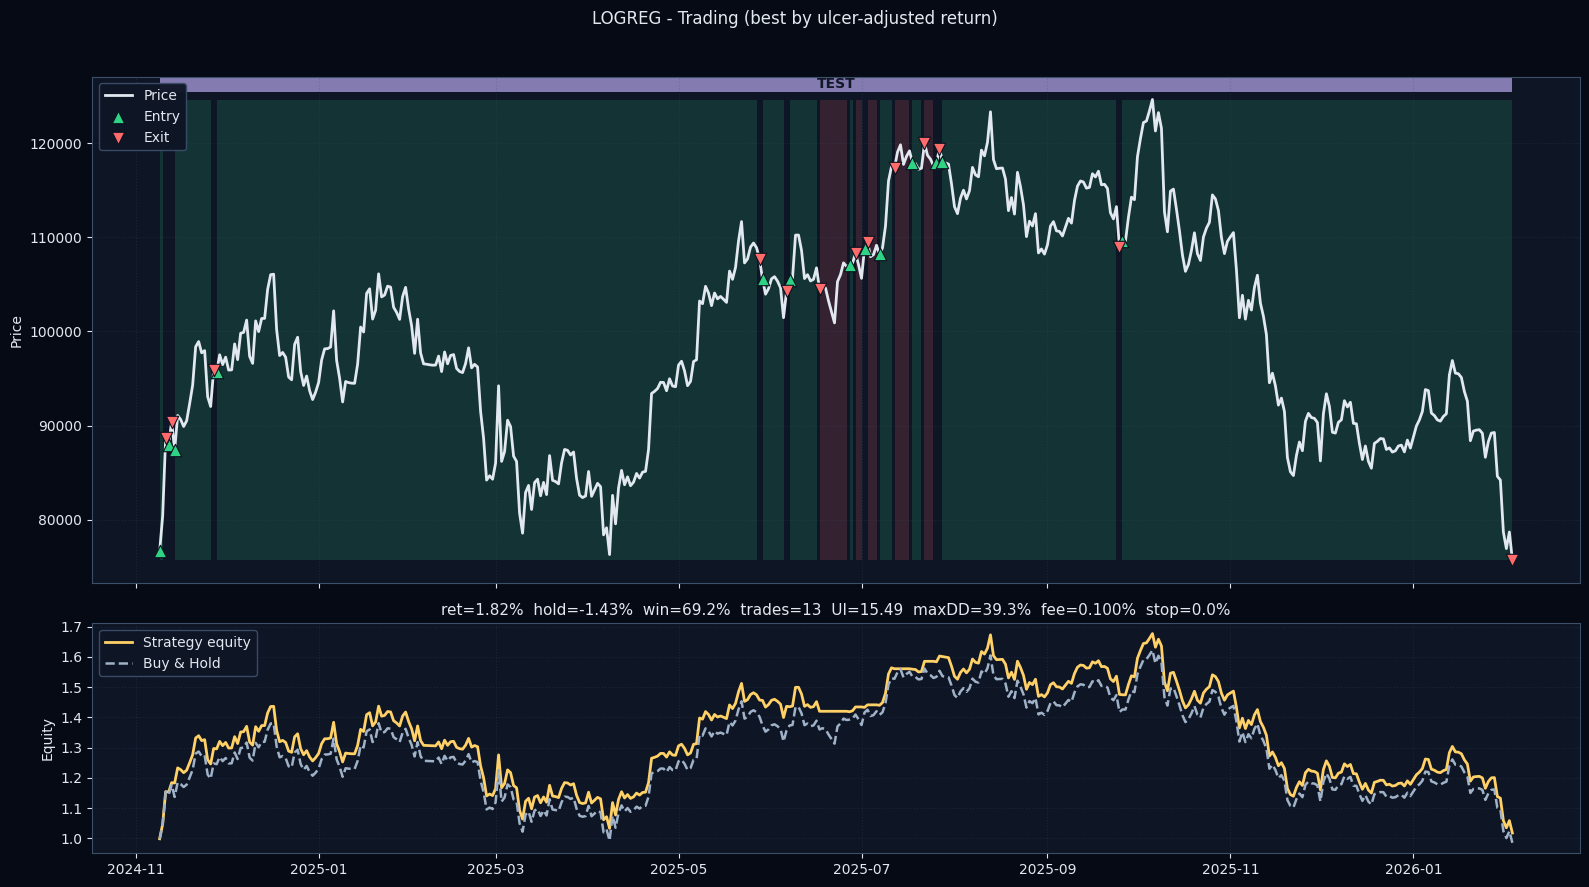


####################################################################################################
TRADING CHECK FOR MODEL: mlp
Base trading metrics: {'final_equity': 1.1767945923814311, 'hold_final_equity': 0.9857308426386139, 'return_pct': 0.17679459238143114, 'hold_return_pct': -0.01426915736138612, 'excess_return_pct': 0.19382953386278956, 'num_trades': 24, 'winrate': 0.375, 'max_drawdown_pct': 33.552134741131255, 'ulcer_index': 12.370883319947437, 'exposure_pct': 68.36283185840708, 'ulcer_adjusted_return': 0.014291185827964169}


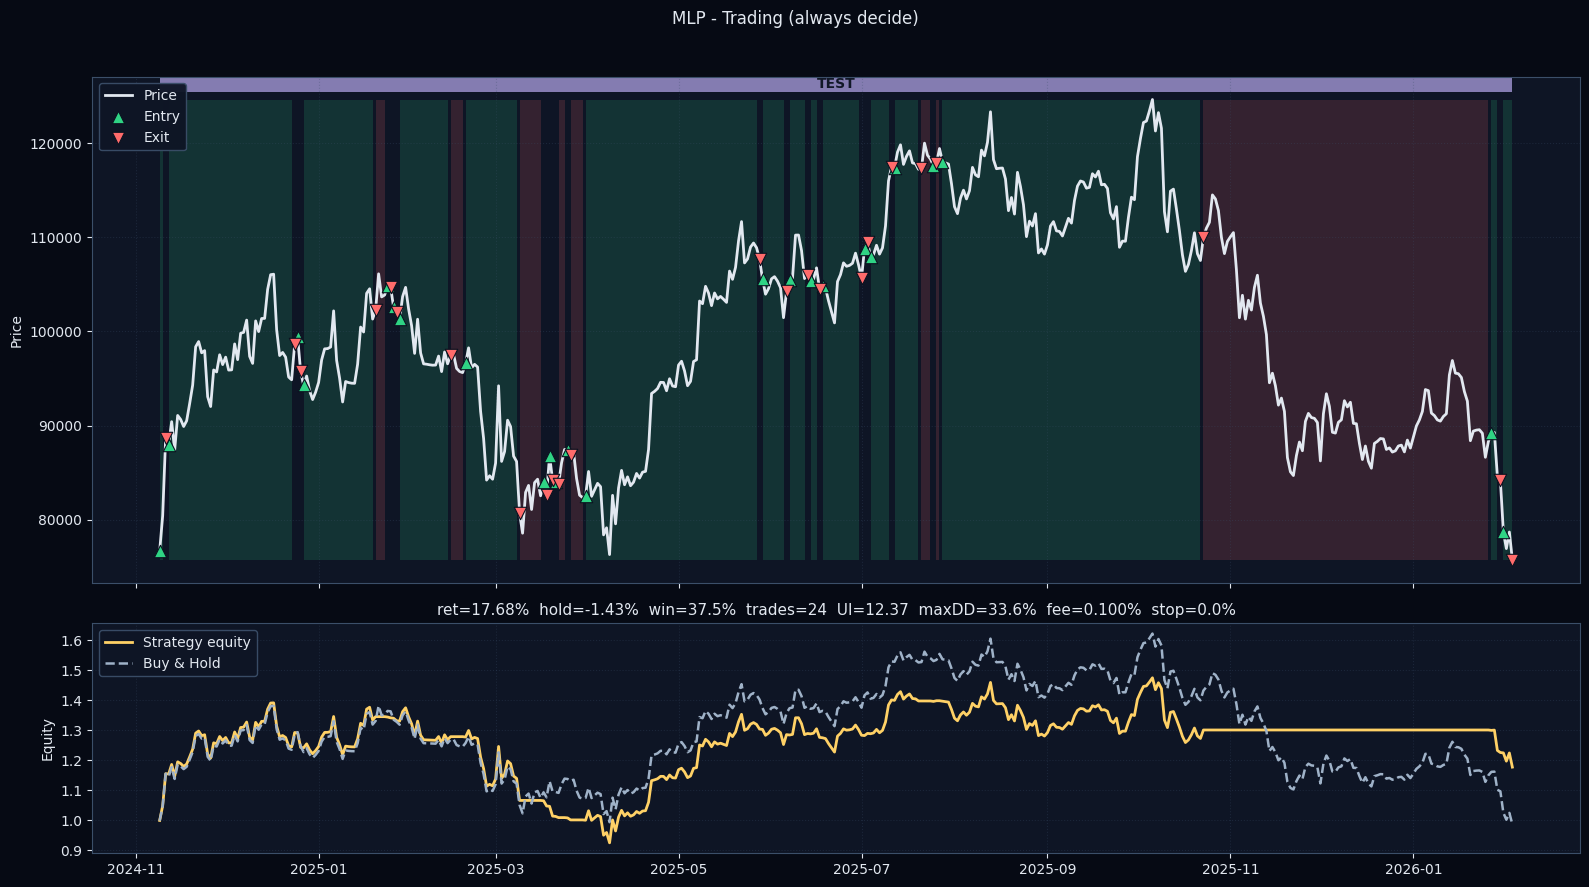

[sweep 1/8] left=7 stop=0.000 exit_no_sig=False | ret=38.184% UI=8.80 win=48.5% | BEST score=0.0434
[sweep 2/8] left=6 stop=0.000 exit_no_sig=True | ret=38.184% UI=8.80 win=48.5% | BEST score=0.0434
[sweep 3/8] left=5 stop=0.020 exit_no_sig=False | ret=10.019% UI=11.32 win=39.5% | BEST score=0.0434
[sweep 4/8] left=4 stop=0.020 exit_no_sig=True | ret=10.019% UI=11.32 win=39.5% | BEST score=0.0434
[sweep 5/8] left=3 stop=0.050 exit_no_sig=False | ret=43.735% UI=7.92 win=48.6% | BEST score=0.0552
[sweep 6/8] left=2 stop=0.050 exit_no_sig=True | ret=43.735% UI=7.92 win=48.6% | BEST score=0.0552
[sweep 7/8] left=1 stop=0.080 exit_no_sig=False | ret=38.184% UI=8.80 win=48.5% | BEST score=0.0552
[sweep 8/8] left=0 stop=0.080 exit_no_sig=True | ret=38.184% UI=8.80 win=48.5% | BEST score=0.0552


final_equity  hold_final_equity  return_pct  hold_return_pct  excess_return_pct  num_trades   winrate  max_drawdown_pct  ulcer_index  exposure_pct  \
0      1.437346           0.985731    0.437346        -0.014269           0.458152          35  0.485714         20.258843     7.921485     60.840708   
1      1.437346           0.985731    0.437346        -0.014269           0.458152          35  0.485714         20.258843     7.921485     60.840708   
2      1.381838           0.985731    0.381838        -0.014269           0.401841          33  0.484848         21.869183     8.798607     61.725664   
3      1.381838           0.985731    0.381838        -0.014269           0.401841          33  0.484848         21.869183     8.798607     61.725664   
4      1.381838           0.985731    0.381838        -0.014269           0.401841          33  0.484848         21.869183     8.798607     61.725664   
5      1.381838           0.985731    0.381838        -0.014269           0.401841          33  0.484848         21.869183     8.798607     61.725664   
6      1.100187           0.985731    0.100187        -0.014269           0.116113          43  0.395349         26.350952    11.322357     58.628319   
7      1.100187           0.985731    0.100187        -0.014269           0.116113          43  0.395349         26.350952    11.322357     58.628319   

   ulcer_adjusted_return  stop_loss_pct  exit_on_no_signal  
0               0.055210           0.05              False  
1               0.055210           0.05               True  
2               0.043397           0.00              False  
3               0.043397           0.00               True  
4               0.043397           0.08              False  
5               0.043397           0.08               True  
6               0.008849           0.02              False  
7               0.008849           0.02               True

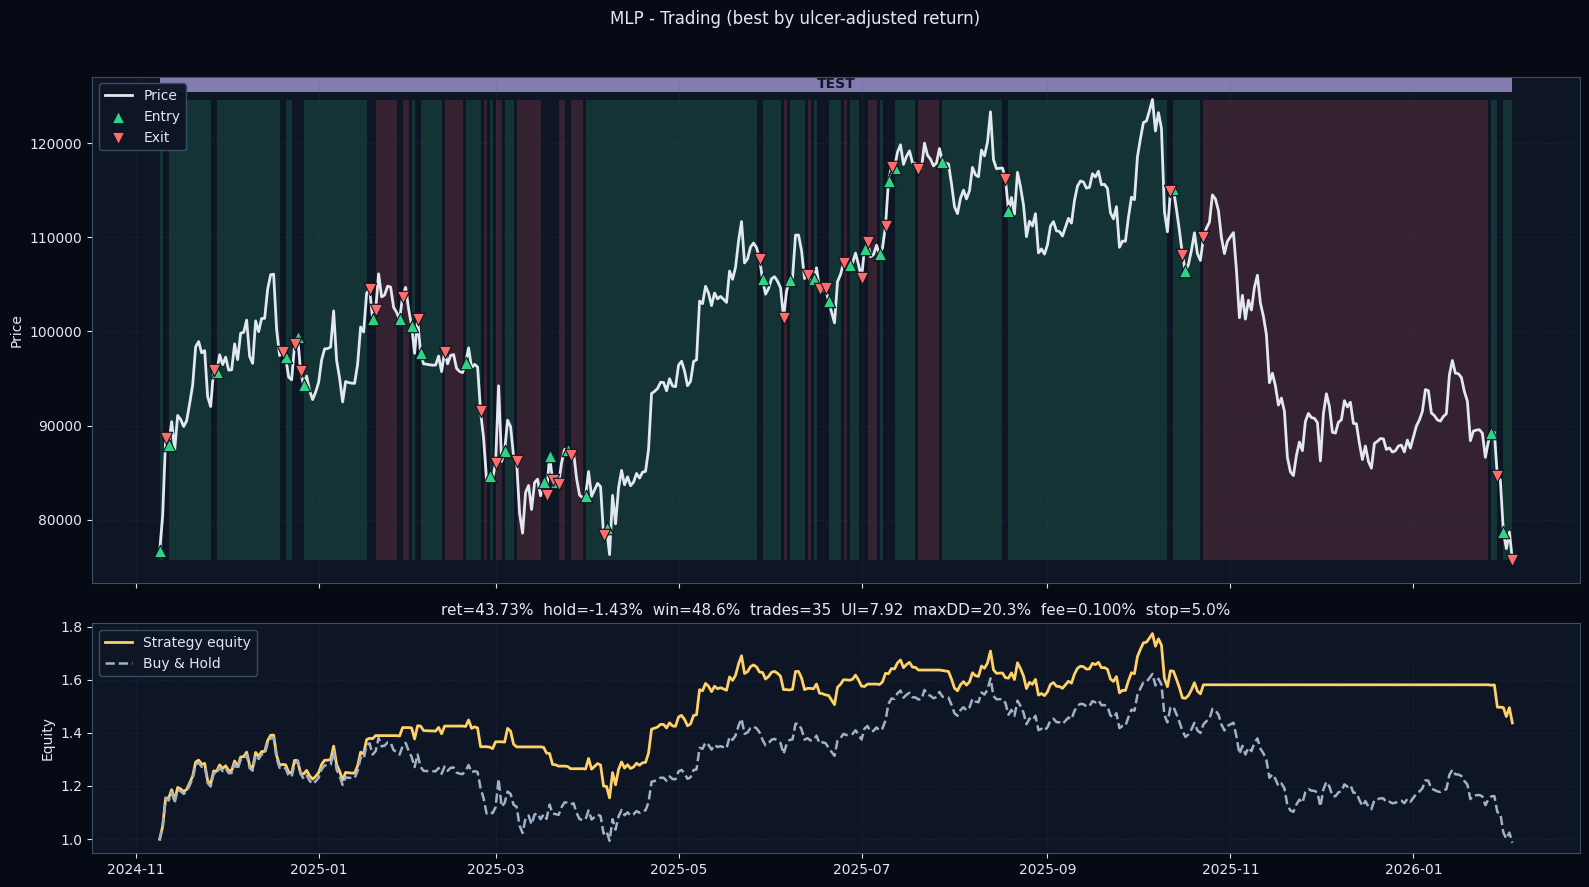


####################################################################################################
TRADING CHECK FOR MODEL: rf
Base trading metrics: {'final_equity': 0.9329875374944622, 'hold_final_equity': 0.9857308426386139, 'return_pct': -0.06701246250553783, 'hold_return_pct': -0.01426915736138612, 'excess_return_pct': -0.053506802123557295, 'num_trades': 6, 'winrate': 0.5, 'max_drawdown_pct': 39.29424842632304, 'ulcer_index': 14.949102307900818, 'exposure_pct': 55.75221238938053, 'ulcer_adjusted_return': -0.004482708133592796}


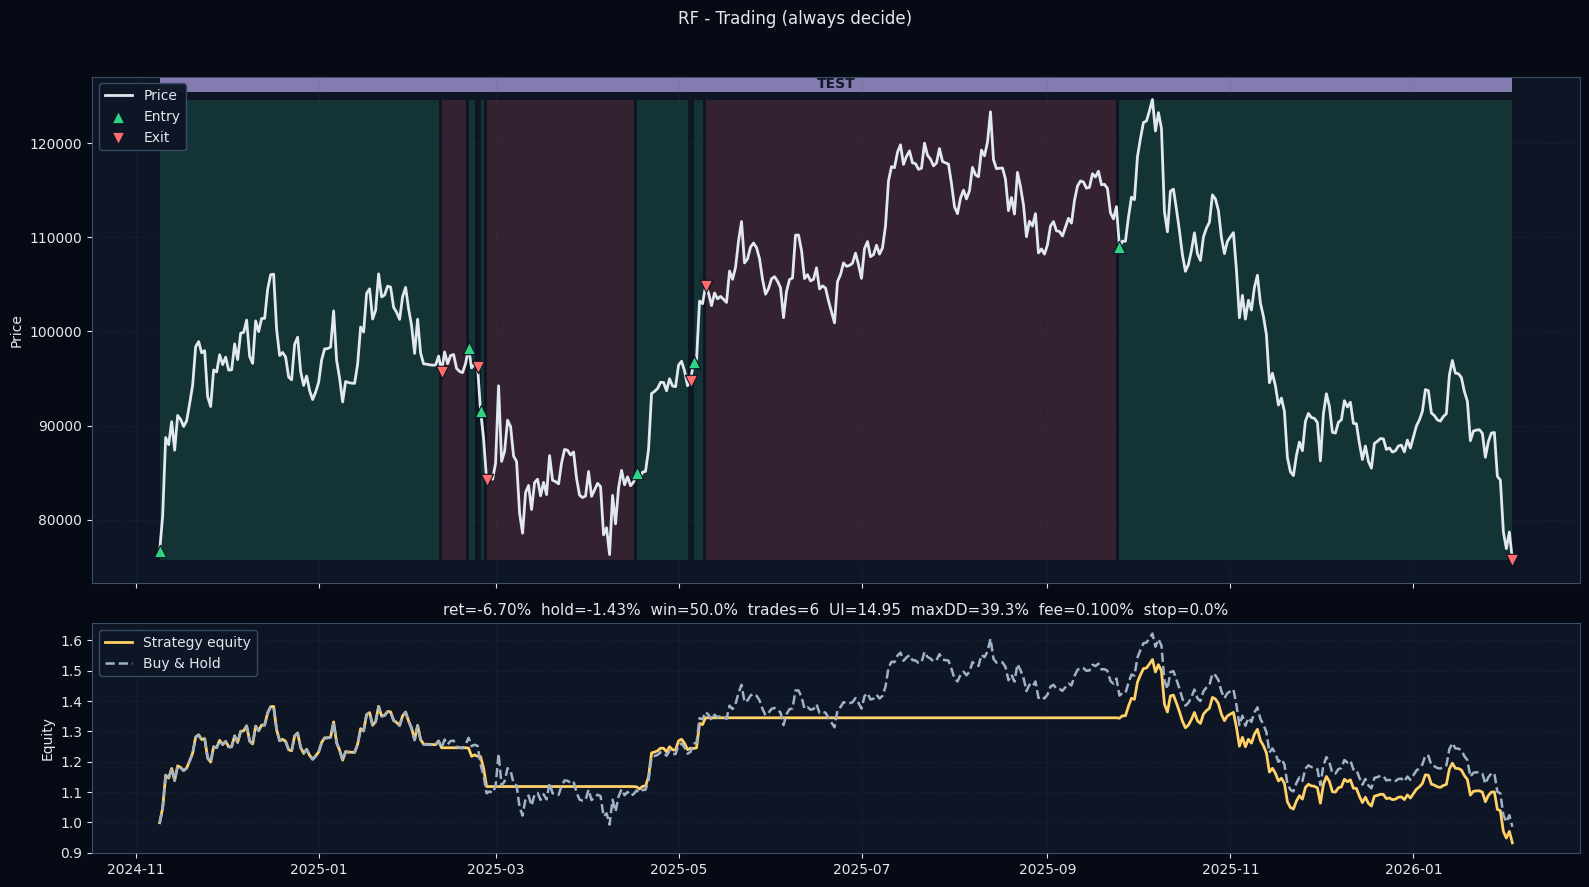

[sweep 1/8] left=7 stop=0.000 exit_no_sig=False | ret=-15.853% UI=14.58 win=50.0% | BEST score=-0.0109
[sweep 2/8] left=6 stop=0.000 exit_no_sig=True | ret=5.186% UI=12.49 win=66.7% | BEST score=0.00415
[sweep 3/8] left=5 stop=0.020 exit_no_sig=False | ret=-10.456% UI=14.00 win=12.5% | BEST score=0.00415
[sweep 4/8] left=4 stop=0.020 exit_no_sig=True | ret=6.170% UI=12.36 win=37.5% | BEST score=0.00499
[sweep 5/8] left=3 stop=0.050 exit_no_sig=False | ret=-15.243% UI=15.46 win=16.7% | BEST score=0.00499
[sweep 6/8] left=2 stop=0.050 exit_no_sig=True | ret=12.384% UI=10.86 win=60.0% | BEST score=0.0114
[sweep 7/8] left=1 stop=0.080 exit_no_sig=False | ret=-16.412% UI=15.22 win=20.0% | BEST score=0.0114
[sweep 8/8] left=0 stop=0.080 exit_no_sig=True | ret=5.489% UI=12.45 win=60.0% | BEST score=0.0114


final_equity  hold_final_equity  return_pct  hold_return_pct  excess_return_pct  num_trades   winrate  max_drawdown_pct  ulcer_index  exposure_pct  \
0      1.123840           0.985731    0.123840        -0.014269           0.140109           5  0.600000         22.729906    10.855058     41.814159   
1      1.061704           0.985731    0.061704        -0.014269           0.077073           8  0.375000         27.002111    12.358993     41.150442   
2      1.054890           0.985731    0.054890        -0.014269           0.070161           5  0.600000         27.470597    12.449762     41.814159   
3      1.051857           0.985731    0.051857        -0.014269           0.067083           3  0.666667         27.679149    12.494236     42.256637   
4      0.895440           0.985731   -0.104560        -0.014269          -0.091598           8  0.125000         35.233478    14.001463     43.805310   
5      0.847572           0.985731   -0.152428        -0.014269          -0.140159           6  0.166667         38.695708    15.459033     44.247788   
6      0.835880           0.985731   -0.164120        -0.014269          -0.152020           5  0.200000         39.541411    15.217845     44.690265   
7      0.841470           0.985731   -0.158530        -0.014269          -0.146349           2  0.500000         39.137083    14.577337     45.796460   

   ulcer_adjusted_return  stop_loss_pct  exit_on_no_signal  
0               0.011409           0.05               True  
1               0.004993           0.02               True  
2               0.004409           0.08               True  
3               0.004150           0.00               True  
4              -0.007468           0.02              False  
5              -0.009860           0.05              False  
6              -0.010785           0.08              False  
7              -0.010875           0.00              False

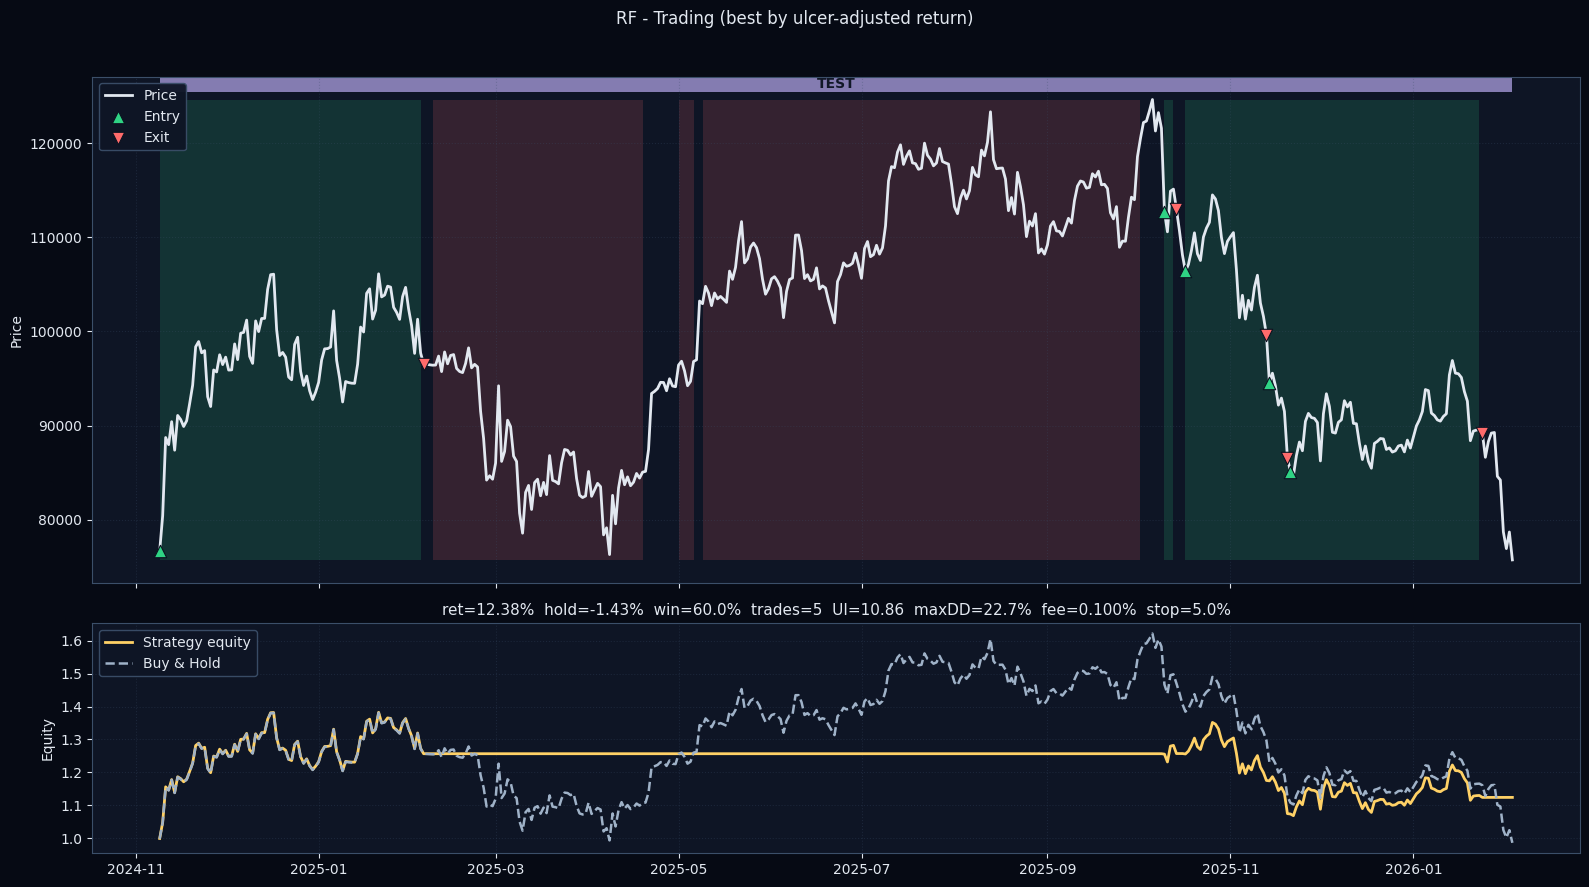


####################################################################################################
TRADING CHECK FOR MODEL: xgb
Base trading metrics: {'final_equity': 1.1594756080137378, 'hold_final_equity': 0.9857308426386139, 'return_pct': 0.15947560801373784, 'hold_return_pct': -0.01426915736138612, 'excess_return_pct': 0.17625984483760515, 'num_trades': 13, 'winrate': 0.6153846153846154, 'max_drawdown_pct': 24.486586927814034, 'ulcer_index': 10.654133374344584, 'exposure_pct': 40.707964601769916, 'ulcer_adjusted_return': 0.014968426094398165}


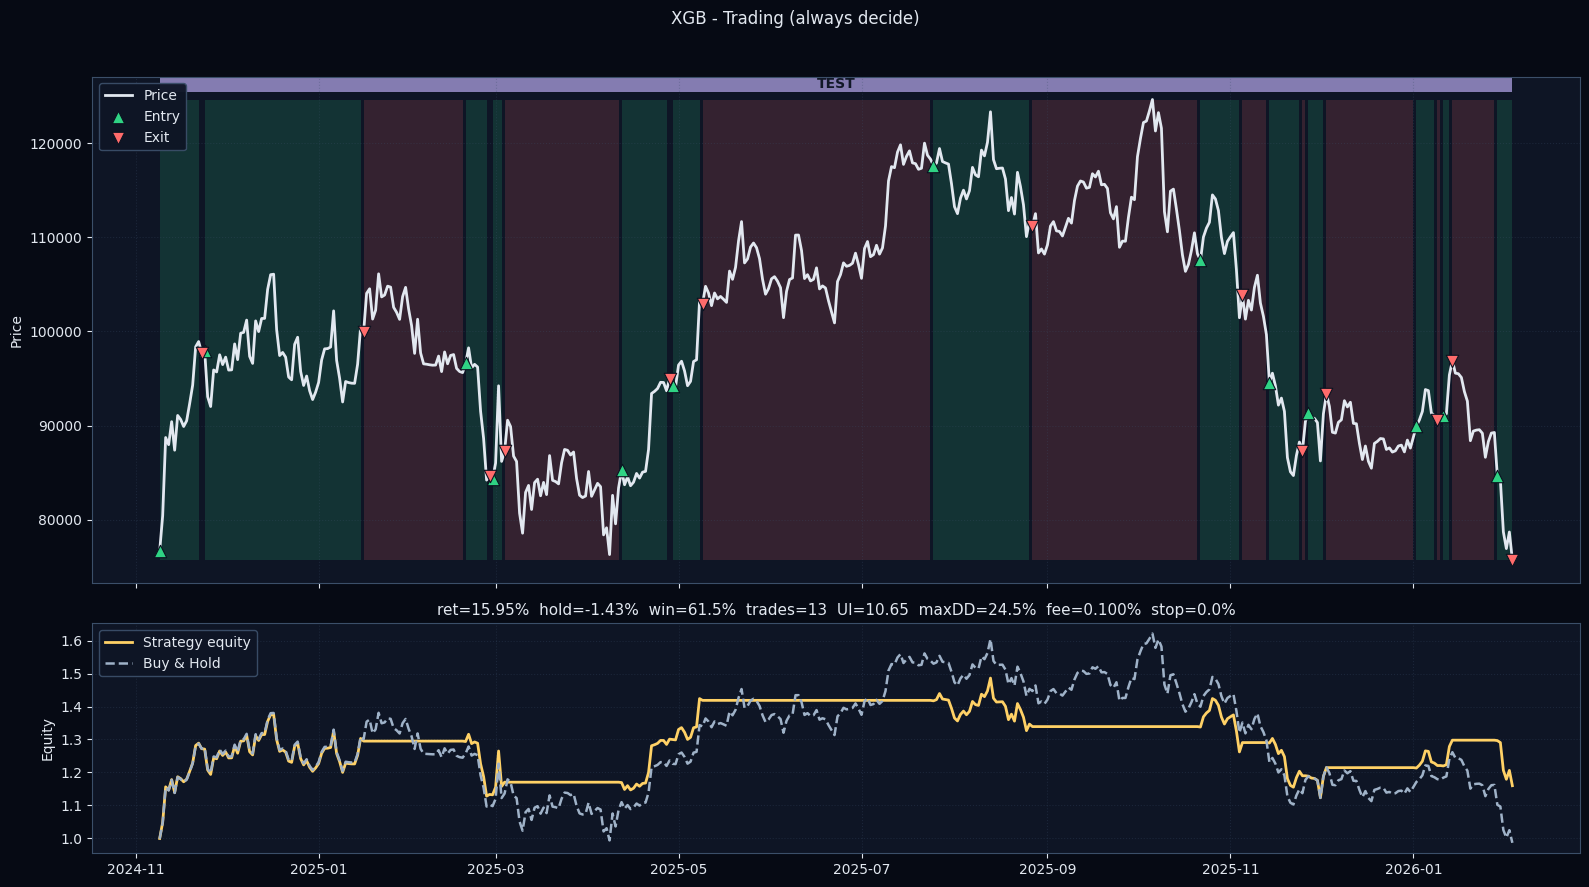

[sweep 1/8] left=7 stop=0.000 exit_no_sig=False | ret=0.901% UI=13.57 win=33.3% | BEST score=0.000664
[sweep 2/8] left=6 stop=0.000 exit_no_sig=True | ret=15.948% UI=10.65 win=61.5% | BEST score=0.015
[sweep 3/8] left=5 stop=0.020 exit_no_sig=False | ret=13.136% UI=12.65 win=26.7% | BEST score=0.015
[sweep 4/8] left=4 stop=0.020 exit_no_sig=True | ret=12.075% UI=12.62 win=42.9% | BEST score=0.015
[sweep 5/8] left=3 stop=0.050 exit_no_sig=False | ret=13.835% UI=11.92 win=25.0% | BEST score=0.015
[sweep 6/8] left=2 stop=0.050 exit_no_sig=True | ret=7.507% UI=12.36 win=47.4% | BEST score=0.015
[sweep 7/8] left=1 stop=0.080 exit_no_sig=False | ret=8.539% UI=13.13 win=40.0% | BEST score=0.015
[sweep 8/8] left=0 stop=0.080 exit_no_sig=True | ret=20.704% UI=9.61 win=62.5% | BEST score=0.0215


final_equity  hold_final_equity  return_pct  hold_return_pct  excess_return_pct  num_trades   winrate  max_drawdown_pct  ulcer_index  exposure_pct  \
0      1.207043           0.985731    0.207043        -0.014269           0.224516          16  0.625000         23.302166     9.608228     40.044248   
1      1.159476           0.985731    0.159476        -0.014269           0.176260          13  0.615385         24.486587    10.654133     40.707965   
2      1.138348           0.985731    0.138348        -0.014269           0.154827          12  0.250000         30.841907    11.916735     52.876106   
3      1.131359           0.985731    0.131359        -0.014269           0.147736          15  0.266667         31.054372    12.647841     49.557522   
4      1.120746           0.985731    0.120746        -0.014269           0.136970          21  0.428571         27.448869    12.619256     38.495575   
5      1.085391           0.985731    0.085391        -0.014269           0.101103          10  0.400000         35.323100    13.129759     55.309735   
6      1.075073           0.985731    0.075073        -0.014269           0.090635          19  0.473684         26.714214    12.355287     39.159292   
7      1.009012           0.985731    0.009012        -0.014269           0.023618           6  0.333333         36.837460    13.572591     56.194690   

   ulcer_adjusted_return  stop_loss_pct  exit_on_no_signal  
0               0.021549           0.08               True  
1               0.014968           0.00               True  
2               0.011610           0.05              False  
3               0.010386           0.02              False  
4               0.009568           0.02               True  
5               0.006504           0.08              False  
6               0.006076           0.05               True  
7               0.000664           0.00              False

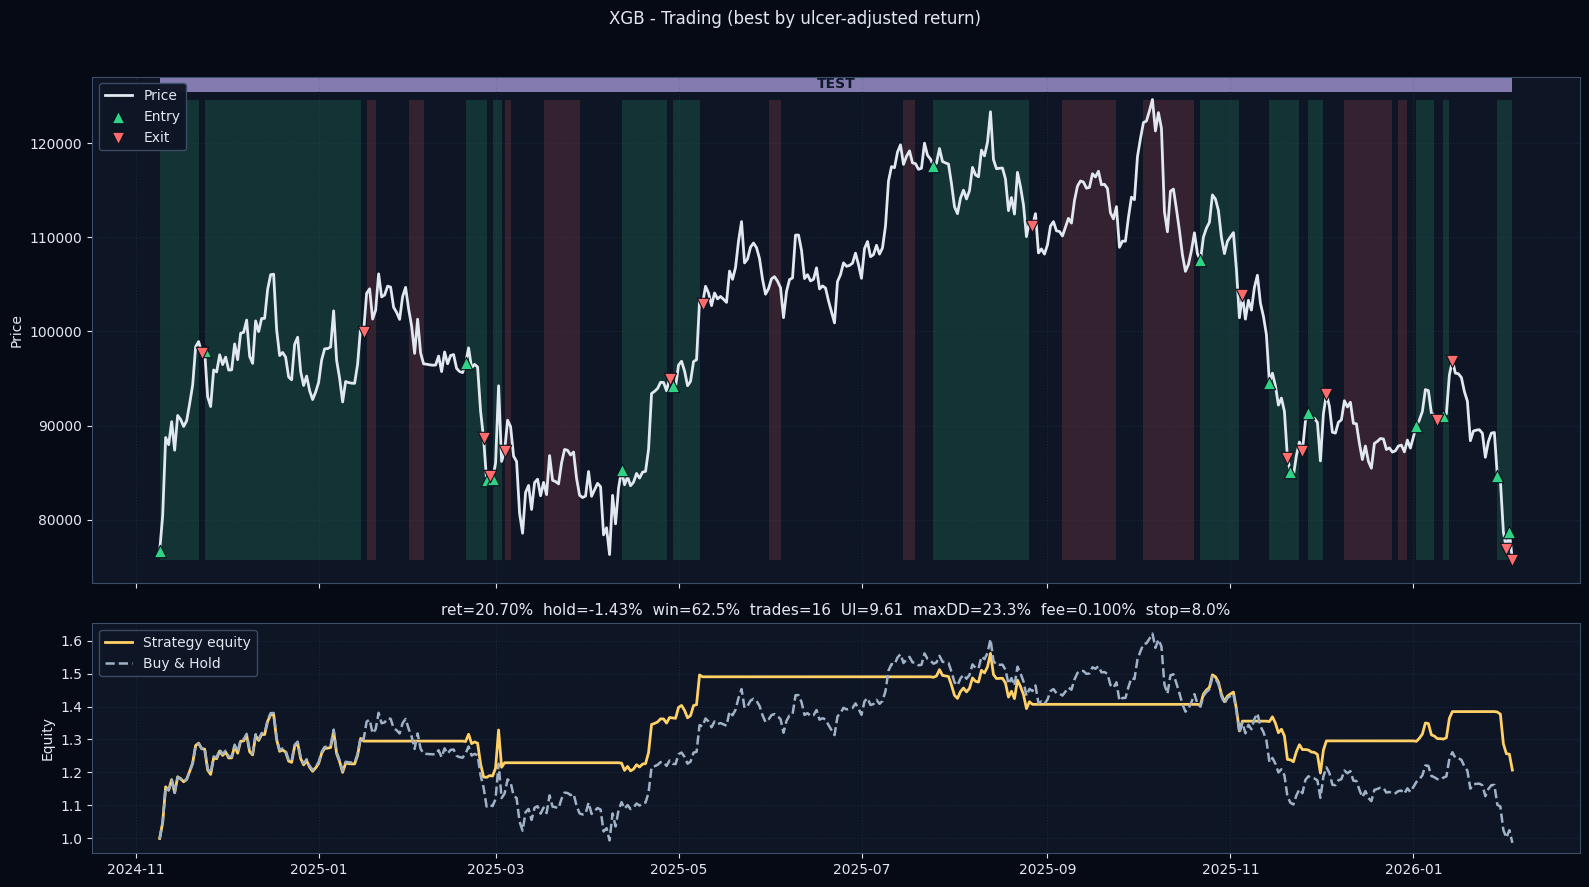

In [15]:
# ------------------------------
# Trading backtest for each winner model (TEST period only)
# ------------------------------

FEE_RATE = 0.001  # 0.1%
STOP_LOSSES = [0.0, 0.02, 0.05, 0.08]  # 0%, 2%, 5%, 8%

# Neutral zone for 'no signal' example (optional).
# If prob is between [DOWN_TH, UP_TH], we set NaN => 'no-signal'.
ZONE = 0.01
UP_TH = 0.5 + ZONE
DOWN_TH = 0.5 - ZONE

for model_name, run in best_runs.items():
    print()
    print('#' * 100)
    print('TRADING CHECK FOR MODEL:', model_name)

    pred = run['predictions'].copy()
    test_df = pred[pred['split_role'] == 'test'].copy().reset_index(drop=True)
    test_df = test_df.dropna(subset=['pred_label', 'close'])

    # 1) Base trading signal: always decide (UP/DOWN).
    test_df['trade_signal'] = test_df['pred_label'].astype(float)

    base_cfg = TradingConfig(
        fee_rate=FEE_RATE,
        stop_loss_pct=0.0,
        exit_on_no_signal=False,
        close_final_position=True,
        initial_cash=1.0,
    )

    base_run = backtest_long_flat_signals(test_df, signal_col='trade_signal', cfg=base_cfg)
    print('Base trading metrics:', base_run['metrics'])
    plot_backtest_price_and_equity(base_run, title=f'{model_name.upper()} - Trading (always decide)', vis_cfg=VIS_CFG)

    # 2) Optional neutral-zone signal: model can say 'I am not sure'.
    # This can reduce overtrading when probabilities are near 0.50.
    test_df['trade_signal_neutral'] = build_signal_from_proba(
        test_df['pred_proba_up'].to_numpy(dtype=float),
        threshold_up=UP_TH,
        threshold_down=DOWN_TH,
    )

    # Quick sweep: try a few stop-loss values and the 'exit on no-signal' switch.
    sweep = sweep_trading_params(
        df=test_df,
        signal_col='trade_signal_neutral',
        stop_losses=STOP_LOSSES,
        exit_on_no_signal_options=(False, True),
        fee_rate=FEE_RATE,
        close_final_position=True,
        initial_cash=1.0,
        verbose=True,
    )

    display(sweep['results_table'].head(10))
    if sweep['best_run'] is not None:
        plot_backtest_price_and_equity(
            sweep['best_run'],
            title=f'{model_name.upper()} - Trading (best by ulcer-adjusted return)',
            vis_cfg=VIS_CFG,
        )
